In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

lat_a=0.1163
lat_NL=48; lat_NT=48
lat_L=lat_a*lat_NL
hbarc = 1/197.327
lat_aInv=1/(lat_a*hbarc)

In [2]:
path='/capstor/store/cscs/userlab/s1174/lyan/code/glwc2/project2/03_NpiScatteringWilson/dataPrepare/A15/data_aux/cfgs_CGWokringCPU'
with open(path,'r') as f:
    cfgs=f.read().splitlines()

def symmetrize(dat):
    dat_bw=np.roll(np.flip(dat,axis=1),1,axis=1)
    return((dat[:,:,0]+dat[:,:,5]) - (dat_bw[:,:,10]+dat_bw[:,:,15]))/4

d_jk=1
Nsrc=3000
path=f'/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/03_NpiScatteringWilson/A15/data_merge/NpiScatteringWilson_Nsrc={Nsrc}.h5'
data={}
with h5py.File(path) as f:    
    cfgs_all=[cfg.decode() for cfg in f['cfgs'][:]]
    cfgs_map=[cfgs_all.index(cfg) for cfg in cfgs]
    
    if True:
        cfgs_map=[cfgs_all.index(cfg) for cfg in cfgs_all]
    print(len(cfgs_map))
    
    for cont in f['data'].keys():
        if cont in ['N']:
            t=f[f'data/{cont}'][:,:,16]
            t=symmetrize(t)
            data[cont]=yu.jackknife(t[cfgs_map],d=d_jk)
            continue
        if cont in ['P','P_hybrid']:
            t=f[f'data/{cont}'][:,:,0]
            t_bw=np.roll(np.flip(t,axis=1),1,axis=1)
            t=(t+t_bw)/2
            data[cont]=yu.jackknife(t[cfgs_map],d=d_jk)
            continue
        t=f[f'data/{cont}'][:,:,0]
        t=symmetrize(t)
        data[cont]=yu.jackknife(t[cfgs_map],d=d_jk)

211


In [3]:
tau=1
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t

func=lambda c2pt:C2pt2meff(c2pt,48)
meff_pion=yu.jackmap(func,np.real(data['P']))

mean,err,cov=yu.jackmec(meff_pion)

tmin=10; tmax=14

t=cov[tmin:tmax,tmin:tmax]
tt=np.sqrt(np.diag(t))
t=t/np.outer(tt,tt)
for row in t:
    for ele in row:
        print('{:.2f}'.format(ele),end='  ')
    print()

print()
t=cov[tmin:tmax,tmin:tmax]
evals,evecs=np.linalg.eig(t)
inds=np.argsort(-evals)
evals=evals[inds]; evecs=evecs[:,inds]

for i in range(len(t)):
    print(evals[i])
    print(evecs[:,i])

1.00  0.98  0.97  0.95  
0.98  1.00  0.98  0.96  
0.97  0.98  1.00  0.97  
0.95  0.96  0.97  1.00  

3.568530897577e-06
[0.49581113 0.50614123 0.49813253 0.49985635]
4.982096171682031e-08
[ 0.59163676  0.31490856 -0.18856318 -0.71780392]
2.3257426065322967e-08
[ 0.50195933 -0.28894384 -0.6708232   0.46318952]
1.1904221416117508e-08
[-0.39009499  0.74910955 -0.51604666  0.14267667]


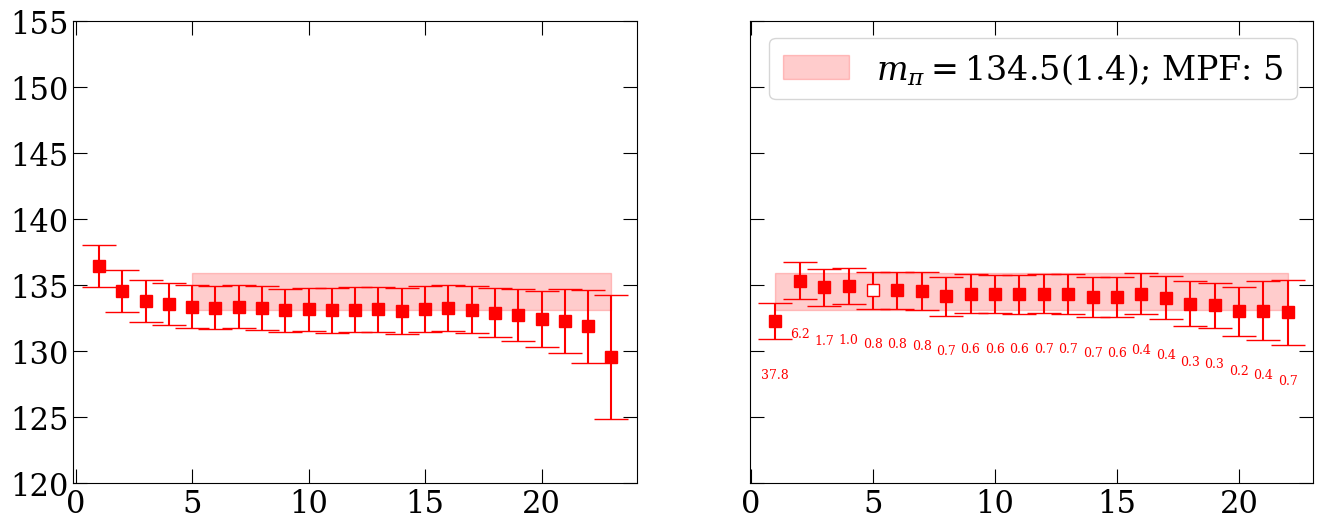

In [31]:
def C2pt2meff(C2pt,totalT):
    t=C2pt
    t=np.arccosh( t/t[totalT//2] ) / np.abs(np.arange(len(t))- totalT//2)
    return t

func=lambda c2pt:C2pt2meff(c2pt,48)
meff_pion=yu.jackmap(func,np.real(data['P']))

error=1/lat_aInv * 1
shape=meff_pion.shape
t=yu.jackknife(np.random.randn(*shape)*error)

meff_pion+=t

fitmax_pion=24
fitmins_pion=range(1,fitmax_pion-1)

m_pi=None
for mask in [None,'uncorrelated'][:1]:
    pars0=[0.08]
    fits=[]
    for fitmin in fitmins_pion:
        tList=np.arange(fitmin,fitmax_pion)
        def fitfunc(pars):
            return [pars[0]]*len(tList)
        y_jk=meff_pion[:,tList]
        
        mean,err,cov=yu.jackmec(y_jk)
        # print(fitmin)
        # print(cov)
        # print(cov/cov[0,0])
        # print(np.linalg.inv(cov))
        # print(np.sum(np.linalg.inv(cov),axis=0))
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=mask)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
    fits_pion=fits

    fig, axs = yu.getFigAxs(1,2,Lrow=6,Lcol=8,sharey=True)
    chi2Size=9
    fig.suptitle(mask)

    ax=axs[0,0]
    xunit=lat_a*0+1; yunit=lat_aInv
    tmin=1; tmax=fitmax_pion
    ax.set_ylim([120,155])
    # ax.axhline(135,color='grey',ls='--')

    mean,err=yu.jackme(meff_pion)
    plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

    pars_jk,props_jk=yu.jackMA(fits)
    # if mask=='uncorrelated':
    #     m_pi=pars_jk[:,0]
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],fitmax_pion-1])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2, label=r'$m_\pi=$'+yu.un2str(plt_y,plt_yerr) + f'; MPF: {fits_pion[ind_mpf][0]}')    
    # ax.legend(fontsize=16)

    ax=axs[0,1]
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2, label=r'$m_\pi=$'+yu.un2str(plt_y,plt_yerr) + f'; MPF: {fits_pion[ind_mpf][0]}') 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='r',mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color='r',size=chi2Size,ha='center') 
    ax.legend()

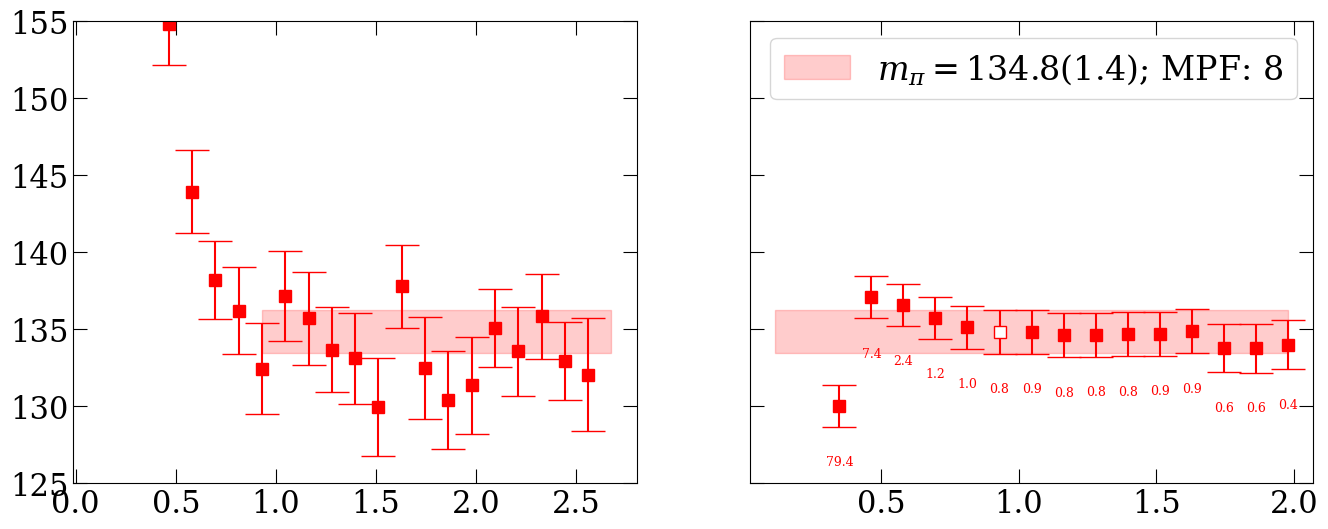

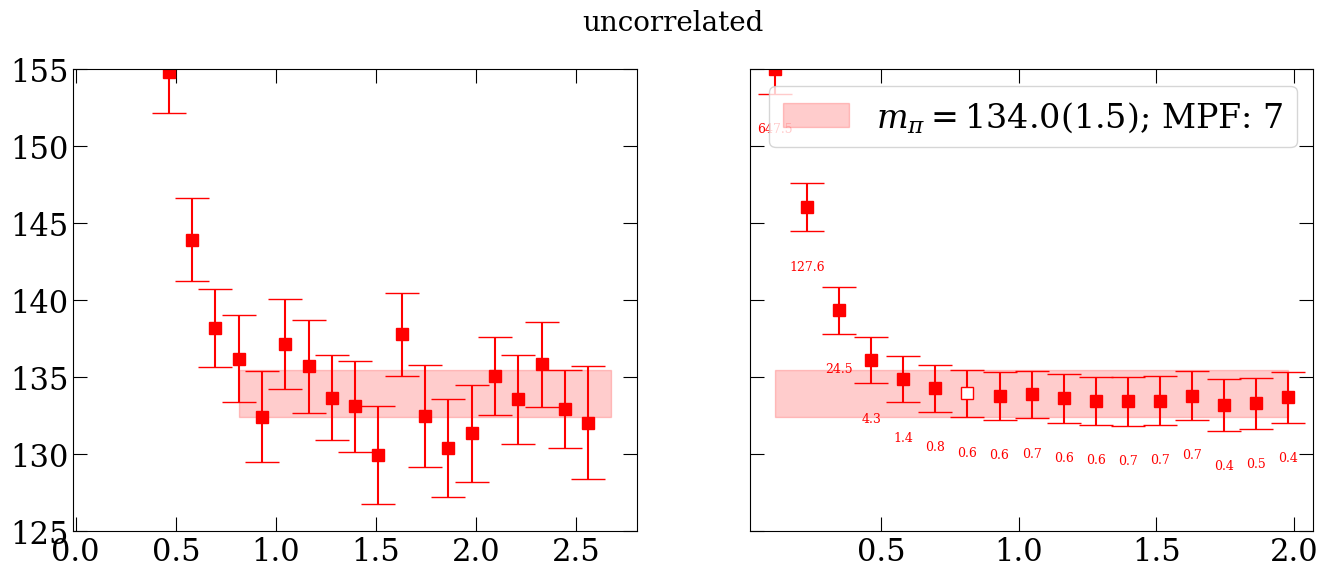

In [ ]:
tau=1
# def C2pt2meff(C2pt,totalT):
#     tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
#     t=C2pt # dim=time
#     t=(np.roll(t,-tau,axis=0))/(t)
#     t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
#     return t
def C2pt2meff(C2pt,totalT):
    t=C2pt
    tP=np.roll(t,-tau,axis=0)
    tM=np.roll(t,+tau,axis=0)
    t=np.arccosh( (tP+tM)/(2*t) )/tau
    return t

func=lambda c2pt:C2pt2meff(c2pt,48)
meff_pion=yu.jackmap(func,np.real(data['P']))

fitmax_pion=24-tau
fitmins_pion=range(tau,fitmax_pion-5)

m_pi=None
for mask in [None,'uncorrelated']:
    pars0=[0.08]
    fits=[]
    for fitmin in fitmins_pion:
        tList=np.arange(fitmin,fitmax_pion)
        def fitfunc(pars):
            return [pars[0]]*len(tList)
        y_jk=meff_pion[:,tList]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=mask)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
    fits_pion=fits

    fig, axs = yu.getFigAxs(1,2,Lrow=6,Lcol=8,sharey=True)
    chi2Size=9
    fig.suptitle(mask)

    ax=axs[0,0]
    xunit=lat_a; yunit=lat_aInv
    tmin=1; tmax=fitmax_pion
    ax.set_ylim([125,155])
    # ax.axhline(135,color='grey',ls='--')

    mean,err=yu.jackme(meff_pion)
    plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

    pars_jk,props_jk=yu.jackMA(fits)
    # if mask=='uncorrelated':
    #     m_pi=pars_jk[:,0]
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],23])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2, label=r'$m_\pi=$'+yu.un2str(plt_y,plt_yerr) + f'; MPF: {fits_pion[ind_mpf][0]}')    
    # ax.legend(fontsize=16)

    ax=axs[0,1]
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2, label=r'$m_\pi=$'+yu.un2str(plt_y,plt_yerr) + f'; MPF: {fits_pion[ind_mpf][0]}') 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='r',mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color='r',size=chi2Size,ha='center') 
    ax.legend()

(211, 3)
[0.07815311 0.07807221 0.07823855]
(3, 3)
[[1.         1.12789095 0.98389382]
 [1.12789095 1.50136368 1.2693615 ]
 [0.98389382 1.2693615  1.70031894]]
[[ 1.         -0.71040284 -0.04830612]
 [-0.71040284  0.77775625 -0.16955224]
 [-0.04830612 -0.16955224  0.24346382]]
[ 1.46505424 -0.62052375  0.15546951]
0.07821658673602991
(211, 1)
[0.07821659]


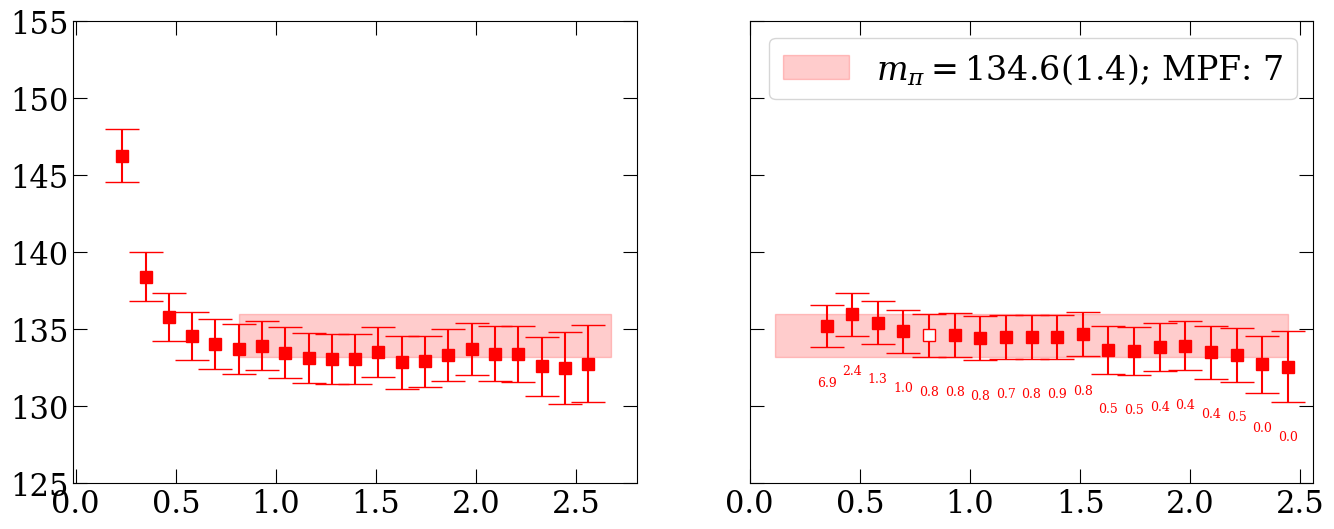

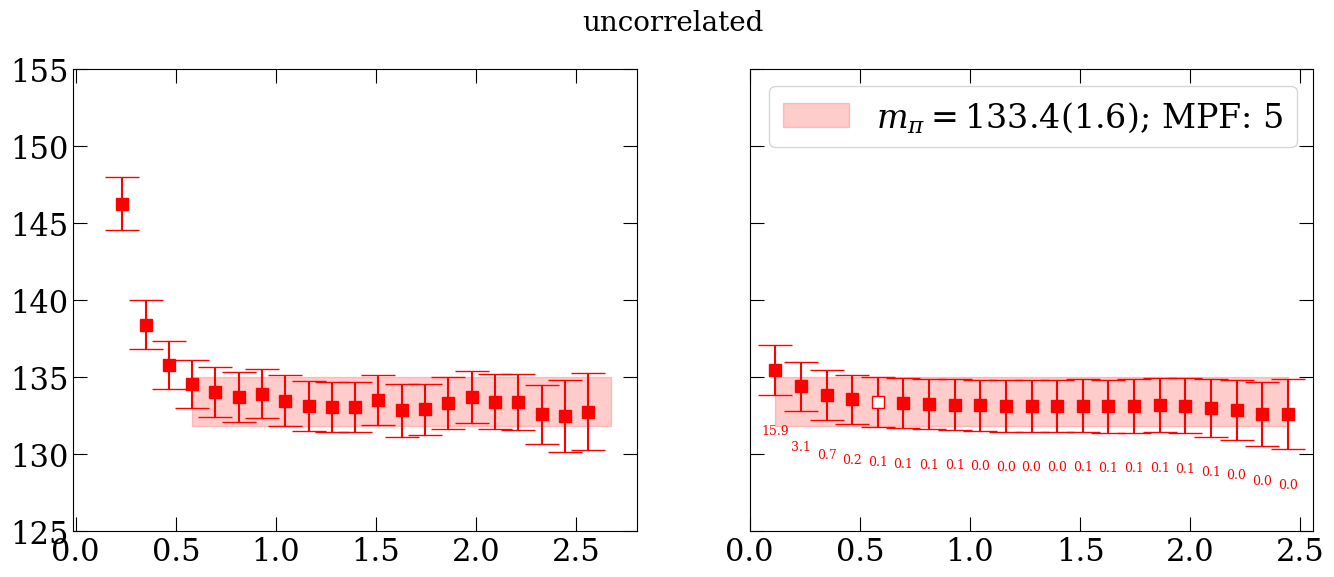

In [4]:
tau=1
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t
func=lambda c2pt:C2pt2meff(c2pt,48)
meff_pion=yu.jackmap(func,np.real(data['P']))

fitmax_pion=24-tau
fitmins_pion=range(1,fitmax_pion-1)

m_pi=None
for mask in [None,'uncorrelated'][:]:
    pars0=[0.08]
    fits=[]
    for fitmin in fitmins_pion:
        tList=np.arange(fitmin,fitmax_pion)
        def fitfunc(pars):
            return [pars[0]]*len(tList)
        y_jk=meff_pion[:,tList]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=mask)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
        if mask is None and fitmin==20:
            print(y_jk.shape)
            print(np.mean(y_jk,axis=0))
            mean,err,cov=yu.jackmec(y_jk)
            print(cov.shape)
            print(cov/cov[0,0])
            covI=np.linalg.inv(cov)
            print(covI/covI[0,0])
            eval,evect=np.linalg.eig(cov)
            one=np.zeros(len(cov))+1
            weights=np.linalg.inv(cov)@one
            weights=weights/np.sum(weights)
            print(weights)
            print(np.sum(np.mean(y_jk,axis=0)*weights))
            print(pars_jk.shape)
            print(np.mean(pars_jk,axis=0))
        
    fits_pion=fits

    fig, axs = yu.getFigAxs(1,2,Lrow=6,Lcol=8,sharey=True)
    chi2Size=9
    fig.suptitle(mask)

    ax=axs[0,0]
    xunit=lat_a; yunit=lat_aInv
    tmin=1; tmax=fitmax_pion
    ax.set_ylim([125,155])
    # ax.axhline(135,color='grey',ls='--')

    mean,err=yu.jackme(meff_pion)
    plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

    pars_jk,props_jk=yu.jackMA(fits)
    if mask!='uncorrelated':
        m_pi=pars_jk[:,0]
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],23])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2, label=r'$m_\pi=$'+yu.un2str(plt_y,plt_yerr) + f'; MPF: {fits_pion[ind_mpf][0]}')    
    # ax.legend(fontsize=16)

    ax=axs[0,1]
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2, label=r'$m_\pi=$'+yu.un2str(plt_y,plt_yerr) + f'; MPF: {fits_pion[ind_mpf][0]}') 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='r',mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color='r',size=chi2Size,ha='center') 
    ax.legend()
    
    plt.savefig('fig/c2pt_pion_correlated.pdf' if mask is None else 'fig/c2pt_pion_uncorrelated.pdf')

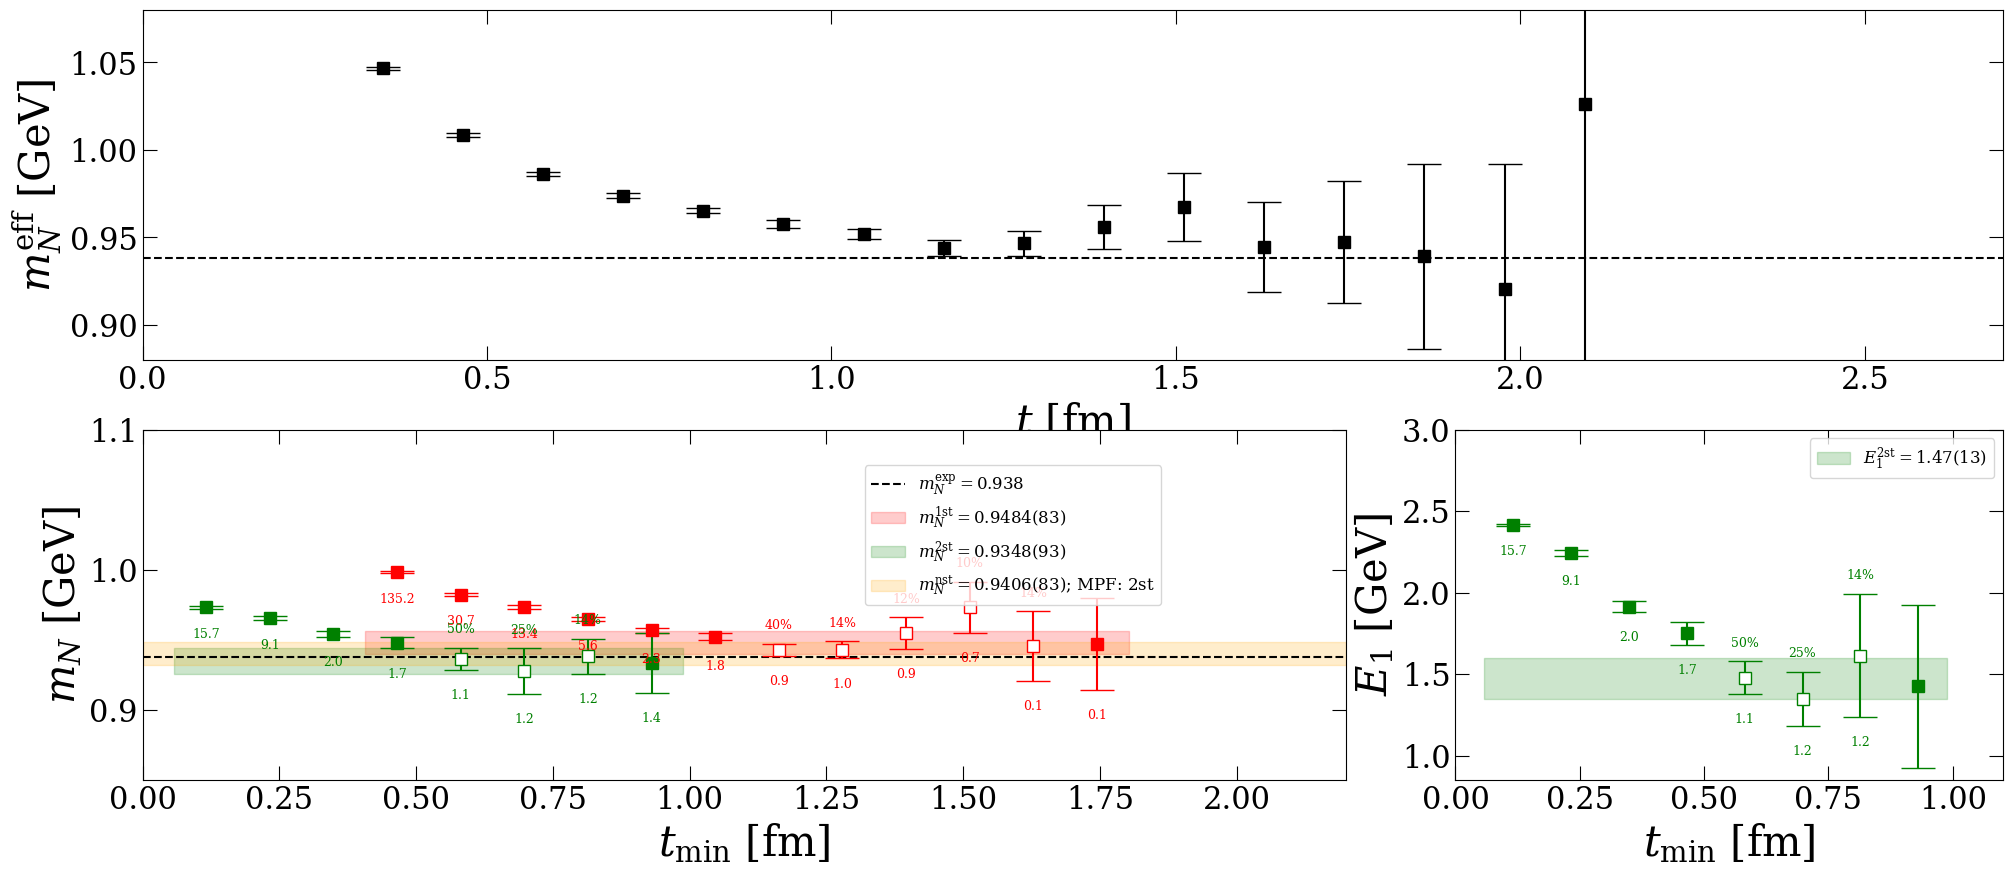

In [5]:
settings={
    'fitmins_1st':range(4,15+1),
    'fitmins_2st':range(1,8+1),
    'fitmins_3st':range(1,6+1),
    'ylim1':[0.6,1.7],
    'ylim1':[0.88,1.08],
    'ylim2':[0.85,1.1],
    'ylim3':[0.85,3.0],
    'xlim1':[0,2.7],
    'xlim2':[0,2.2],
    'xlim3':[0,1.1],
}

m_N=None

propThreshold=0.1

func=lambda c:np.log(c/np.roll(c,-1))
meff_N=yu.jackmap(func,np.real(data['N']))

func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

xUnit=lat_a; yUnit=lat_aInv/1000
fig, axd = plt.subplot_mosaic([['f1','f1','f1'],['f2','f2','f3']],figsize=(24,10))
(ax1,ax2,ax3)=(axd[key] for key in ['f1','f2','f3'])

ax1.set_xlabel(r'$t$ [fm]')
ax2.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
ax3.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
ax1.set_ylabel(r'$m_N^{\mathrm{eff}}$ [GeV]')
ax2.set_ylabel(r'$m_N$ [GeV]')
ax3.set_ylabel(r'$E_1$ [GeV]')
ax1.set_ylim(settings['ylim1'])
ax2.set_ylim(settings['ylim2'])
ax3.set_ylim(settings['ylim3'])
ax1.set_xlim(settings['xlim1'])
ax2.set_xlim(settings['xlim2'])
ax3.set_xlim(settings['xlim3'])

mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
ax1.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
ax2.axhline(y=mN_exp,color='black',linestyle = '--', marker='', label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)

mEff_jk=meff_N
(mEff_mean,mEff_err)=yu.jackme(mEff_jk)
mEff_rela=np.abs(mEff_err/mEff_mean)
temp=[(i,rela) for i,rela in enumerate(mEff_rela) if rela>0.2 and i!=0]
fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1

tmin=1; tmax=fitmax+1
plt_x=np.arange(tmin,tmax)*xUnit; plt_y=mEff_mean[tmin:tmax]*yUnit; plt_err=mEff_err[tmin:tmax]*yUnit
ax1.errorbar(plt_x,plt_y,plt_err,color='black',fmt='s')

meffQ=True; corrQ=True; C2pt_jk=None

pars0_initial=[0.4,0.5,2,0.8,1] if meffQ else [0.4,1e-8,0.5,2,0.8,1]
DNpar=1 if meffQ else 0

fits_all=[]
# 1st fits
color='r'
fitmins=settings['fitmins_1st']
pars0=pars0_initial[:2-DNpar]
fits=[]
for fitmin in fitmins:
    tList=np.arange(fitmin,fitmax)
    def fitfunc(pars):
        if meffQ:
            return func_mEff_1st(tList,*pars)
        return func_C2pt_1st(tList,*pars)
    y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
    pars0=np.mean(pars_jk,axis=0)
    fits.append([fitmin,pars_jk,chi2_jk,Ndof])
    fits_all.append([('1st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    
pars_jk,props_jk=yu.jackMA(fits)
m_N=pars_jk[:,0]
props_mean=np.mean(props_jk,axis=0)
# for i,prop in enumerate(np.mean(props_jk,axis=0)):
#     if prop<0.1:
#         continue
#     fitmin,t_pars_jk,chi2_jk,Ndof=fits[i]
#     print(i,prop,fitmin*xUnit,np.mean(t_pars_jk,axis=0)[0]*yUnit,np.mean(chi2_jk)/Ndof,np.mean(chi2_jk),Ndof)
ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
pars_mean,pars_err=yu.jackme(pars_jk)
pars0=pars_mean
plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2,label=r'$m_N^{\mathrm{1st}}=$'+yu.un2str(plt_y,plt_err))
for i,fit in enumerate(fits):
    fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
    (pars_mean,pars_err)=yu.jackme(pars_jk)
    chi2R=np.mean(chi2_jk)/Ndof
    showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
    
    plt_x=fitmin*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
    ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
    ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
    ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    if propThreshold is not None and prop>propThreshold:
        ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
# 2st fits
color='g'
fitmins=settings['fitmins_2st']
pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
fits=[]
for fitmin in fitmins:
    tList=np.arange(fitmin,fitmax)
    def fitfunc(pars):
        if meffQ:
            return func_mEff_2st(tList,*pars)
        return func_C2pt_2st(tList,*pars)
    y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
    pars0=np.mean(pars_jk,axis=0)
    fits.append([fitmin,pars_jk,chi2_jk,Ndof])
    fits_all.append([('2st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
pars_jk,props_jk=yu.jackMA(fits)
props_mean=np.mean(props_jk,axis=0)
pars0=yu.jackme(pars_jk)[0]
res=pars_jk.copy()
ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
pars_mean,pars_err=yu.jackme(pars_jk)
plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[1]*yUnit; plt_err=pars_err[1]*yUnit
ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
for i,fit in enumerate(fits):
    fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    (pars_mean,pars_err)=yu.jackme(pars_jk)
    chi2R=np.mean(chi2_jk)/Ndof
    showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
    
    plt_x=fitmin*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
    ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
    ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
    ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    if propThreshold is not None and prop>propThreshold:
        ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
    
    plt_x=fitmin*xUnit; plt_y=pars_mean[1]*yUnit; plt_err=pars_err[1]*yUnit
    ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
    ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
    ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    if propThreshold is not None and prop>propThreshold:
        ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
color='orange'
pars_jk,props_jk=yu.jackMA(fits_all)
ind_mpf=np.argmax(np.mean(props_jk,axis=0))
pars_mean,pars_err=yu.jackme(pars_jk)
plt_x=settings['xlim2']; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{nst}}=$'+yu.un2str(plt_y,plt_err) + f'; MPF: {fits_all[ind_mpf][0][0]}')    

ax2.legend(loc=(0.6,0.5),fontsize=12)
ax3.legend(fontsize=12)
plt.savefig(f'fig/c2pt_nucleon_Nsrc={Nsrc}.pdf')

In [6]:
# settings={
#     'fitmins_1st':range(4,15+1),
#     'fitmins_2st':range(1,8+1),
#     'fitmins_3st':range(1,6+1),
#     'ylim1':[0.6,1.7],
#     'ylim1':[0.88,1.08],
#     'ylim2':[0.85,1.1],
#     'ylim3':[0.85,3.0],
#     'xlim1':[0,2.7],
#     'xlim2':[0,2.2],
#     'xlim3':[0,1.1],
# }

# m_N=None

# propThreshold=0.1

# func=lambda c:np.log(c/np.roll(c,-1))
# meff_N=yu.jackmap(func,np.real(data['N']))

# func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
# func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
# func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
# func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
# func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
# func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

# xUnit=lat_a; yUnit=lat_aInv/1000
# fig, axd = plt.subplot_mosaic([['f1','f1','f1'],['f2','f2','f3']],figsize=(24,10))
# (ax1,ax2,ax3)=(axd[key] for key in ['f1','f2','f3'])

# ax1.set_xlabel(r'$t$ [fm]')
# ax2.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
# ax3.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
# ax1.set_ylabel(r'$m_N^{\mathrm{eff}}$ [GeV]')
# ax2.set_ylabel(r'$m_N$ [GeV]')
# ax3.set_ylabel(r'$E_1$ [GeV]')
# ax1.set_ylim(settings['ylim1'])
# ax2.set_ylim(settings['ylim2'])
# ax3.set_ylim(settings['ylim3'])
# ax1.set_xlim(settings['xlim1'])
# ax2.set_xlim(settings['xlim2'])
# ax3.set_xlim(settings['xlim3'])

# mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
# ax1.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
# ax2.axhline(y=mN_exp,color='black',linestyle = '--', marker='', label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)

# mEff_jk=meff_N
# (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
# mEff_rela=np.abs(mEff_err/mEff_mean)
# temp=[(i,rela) for i,rela in enumerate(mEff_rela) if rela>0.2 and i!=0]
# fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1

# tmin=1; tmax=fitmax+1
# plt_x=np.arange(tmin,tmax)*xUnit; plt_y=mEff_mean[tmin:tmax]*yUnit; plt_err=mEff_err[tmin:tmax]*yUnit
# ax1.errorbar(plt_x,plt_y,plt_err,color='black',fmt='s')

# meffQ=True; corrQ=True; C2pt_jk=None

# pars0_initial=[0.4,0.5,2,0.8,1] if meffQ else [0.4,1e-8,0.5,2,0.8,1]
# DNpar=1 if meffQ else 0

# fits_all=[]
# # 1st fits
# color='r'
# fitmins=settings['fitmins_1st']
# pars0=pars0_initial[:2-DNpar]
# fits=[]
# for fitmin in fitmins:
#     tList=np.arange(fitmin,fitmax)
#     def fitfunc(pars):
#         if meffQ:
#             return func_mEff_1st(tList,*pars)
#         return func_C2pt_1st(tList,*pars)
#     y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
#     pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
#     pars0=np.mean(pars_jk,axis=0)
#     fits.append([fitmin,pars_jk,chi2_jk,Ndof])
#     fits_all.append([('1st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    
# pars_jk,props_jk=yu.jackMA(fits)
# m_N=pars_jk[:,0]
# props_mean=np.mean(props_jk,axis=0)
# # for i,prop in enumerate(np.mean(props_jk,axis=0)):
# #     if prop<0.1:
# #         continue
# #     fitmin,t_pars_jk,chi2_jk,Ndof=fits[i]
# #     print(i,prop,fitmin*xUnit,np.mean(t_pars_jk,axis=0)[0]*yUnit,np.mean(chi2_jk)/Ndof,np.mean(chi2_jk),Ndof)
# ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
# pars_mean,pars_err=yu.jackme(pars_jk)
# pars0=pars_mean
# plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2,label=r'$m_N^{\mathrm{1st}}=$'+yu.un2str(plt_y,plt_err))
# for i,fit in enumerate(fits):
#     fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
#     (pars_mean,pars_err)=yu.jackme(pars_jk)
#     chi2R=np.mean(chi2_jk)/Ndof
#     showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
    
#     plt_x=fitmin*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
#     ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
#     ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
#     ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
#     if propThreshold is not None and prop>propThreshold:
#         ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
# # 2st fits
# color='g'
# fitmins=settings['fitmins_2st']
# pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
# fits=[]
# for fitmin in fitmins:
#     tList=np.arange(fitmin,fitmax)
#     def fitfunc(pars):
#         if meffQ:
#             return func_mEff_2st(tList,*pars)
#         return func_C2pt_2st(tList,*pars)
#     y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
#     pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
#     pars0=np.mean(pars_jk,axis=0)
#     fits.append([fitmin,pars_jk,chi2_jk,Ndof])
#     fits_all.append([('2st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
# pars_jk,props_jk=yu.jackMA(fits)
# props_mean=np.mean(props_jk,axis=0)
# pars0=yu.jackme(pars_jk)[0]
# res=pars_jk.copy()
# ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
# pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
# pars_mean,pars_err=yu.jackme(pars_jk)
# plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
# plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[1]*yUnit; plt_err=pars_err[1]*yUnit
# ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
# for i,fit in enumerate(fits):
#     fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
#     pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
#     (pars_mean,pars_err)=yu.jackme(pars_jk)
#     chi2R=np.mean(chi2_jk)/Ndof
#     showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
    
#     plt_x=fitmin*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
#     ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
#     ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
#     ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
#     if propThreshold is not None and prop>propThreshold:
#         ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
    
#     plt_x=fitmin*xUnit; plt_y=pars_mean[1]*yUnit; plt_err=pars_err[1]*yUnit
#     ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
#     ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
#     ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
#     if propThreshold is not None and prop>propThreshold:
#         ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
# color='orange'
# pars_jk,props_jk=yu.jackMA(fits_all)
# ind_mpf=np.argmax(np.mean(props_jk,axis=0))
# pars_mean,pars_err=yu.jackme(pars_jk)
# plt_x=settings['xlim2']; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
# ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{nst}}=$'+yu.un2str(plt_y,plt_err) + f'; MPF: {fits_all[ind_mpf][0][0]}')    

# ax2.legend(loc=(0.6,0.5),fontsize=12)
# ax3.legend(fontsize=12)
# # plt.savefig(f'fig/c2pt_nucleon_Nsrc={Nsrc}.pdf')

In [6]:
# sigma term to lattice scattering length 1/2 # Hoferichter:2016ocj
mpiC_phys=139.57
sgm_center=59.1
a12_center=169.8*1e-3 * (mpiC_phys**-1); a12_error=2.0*1e-3 * (mpiC_phys**-1)
a32_center=-86.3*1e-3 * (mpiC_phys**-1); a32_error=1.8*1e-3 * (mpiC_phys**-1)
a12_center_pheLat=178.8*1e-3 * (mpiC_phys**-1); a12_error_pheLat=3.8*1e-3 * (mpiC_phys**-1)
a32_center_pheLat=-77.5*1e-3 * (mpiC_phys**-1); a32_error_pheLat=3.5*1e-3 * (mpiC_phys**-1)

def a2sgm(a12,a32):
    c12=0.242*1e3*mpiC_phys
    c32=0.874*1e3*mpiC_phys
    return sgm_center + c12*(a12-a12_center) + c32*(a32-a32_center)

def sgm2a12(sgm):    
    c12=0.242*1e3*mpiC_phys
    c32=0.874*1e3*mpiC_phys
    return a12_center + (sgm-sgm_center)/c12

# scattering length <-> energy shift
def sl2es(mu, L, a0):
    c1=-2.837297; c2=6.375183
    return - (2*np.pi)/(mu*L) * a0/L * ( 1 + c1*a0/L + c2*(a0/L)**2 ) / L
def es2sl(mu, L, dE):
    return yu.fsolve2(lambda a0:sl2es(mu, L, a0)-dE, 0)

mN=931; mpi=131
mu=1/(1/mN+1/mpi); L=4.5 * hbarc

print(f'1/2: {sl2es(mu,L,a12_center)}, 3/2: {sl2es(mu,L,a32_center)}')

for sgm in [40,60]:
    print(f'{sgm}: {sl2es(mu,L,sgm2a12(sgm))}')
    
es2sl(mu,L,-5),a12_center

# a2sgm(0.169*mpiC_phys**-1/2,-0.1*mpiC_phys**-1)

a2sgm(0.123*(mpiC_phys**-1),-0.098*(mpiC_phys**-1))

mN=938/lat_aInv
mpi=140/lat_aInv
mu=1/(1/mN+1/mpi) 
L=48

# def sl2es(a0):
#     c1=-2.837297; c2=6.375183
#     return - (2*np.pi)/(mu*L) * a0/L * ( 1 + c1*a0/L + c2*(a0/L)**2 ) / L
# def es2sl(dE):
#     return yu.fsolve2(lambda a0:sl2es(a0)-dE, 0)


a12_center=169.8*1e-3 * (mpiC_phys**-1); a12_error=2.0*1e-3 * (mpiC_phys**-1)
a32_center=-86.3*1e-3 * (mpiC_phys**-1); a32_error=1.8*1e-3 * (mpiC_phys**-1)

1/2: -4.86473912395479, 3/2: 3.085302012686854
40: -2.775974591170151
60: -4.956882313254664


In [7]:
# scattering length <-> energy shift
def sl2es(mu, L, a0):
    c1=-2.837297; c2=6.375183
    return - (2*np.pi)/(mu*L) * a0/L * ( 1 + c1*a0/L + c2*(a0/L)**2 ) / L
def es2sl(mu, L, dE):
    res=yu.fsolve2(lambda a0:sl2es(mu, L, a0)-dE, 0)
    # print(res)
    return res

m_mu=[1/(1/mpi+1/mN) for mpi,mN in zip(m_pi,m_N)] # lat unit

a32mpi_phy=(-86.3*1e-3,1.8*1e-3); a12mpi_phy=(169.8*1e-3,2.0*1e-3)
# a32mpi_phy=(-77.5*1e-3,3.5*1e-3); a12mpi_phy=(178.8*1e-3,3.8*1e-3)

a32mpi_pol=(-0.128,0.015); a12mpi_pol=(0.093,0.025)
a32mpi_delta=(-0.13,0.04)

print(a2sgm(a12mpi_phy[0]/mpiC_phys,a32mpi_phy[0]/mpiC_phys))
print(a2sgm(a12mpi_pol[0]/mpiC_phys,a32mpi_pol[0]/mpiC_phys))


59.100000000000016
4.068599999999996


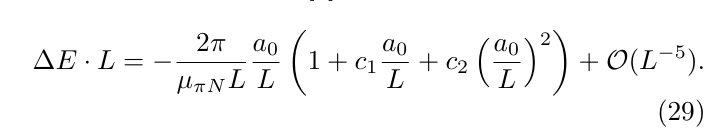

$\Delta E \sim L^{-3}$

L ~ 4.63/4.58 (polarizability), 5.1 (delta), 5.6 (Wilson)

In [ ]:
lat_a,lat_aInv, lat_a*48

(0.1163, 1696.7067927773003, 5.5824)

[16, 16]
-11(24)
0.00012426855137909426 -0.0008910806262767677
0.0012165938238876551 -0.0006183277208569177
22.2(6.0) a12 from wilson, a32 from phe
26(19) a12 from phe, a32 from wilson
59.100000000000016 both from phe


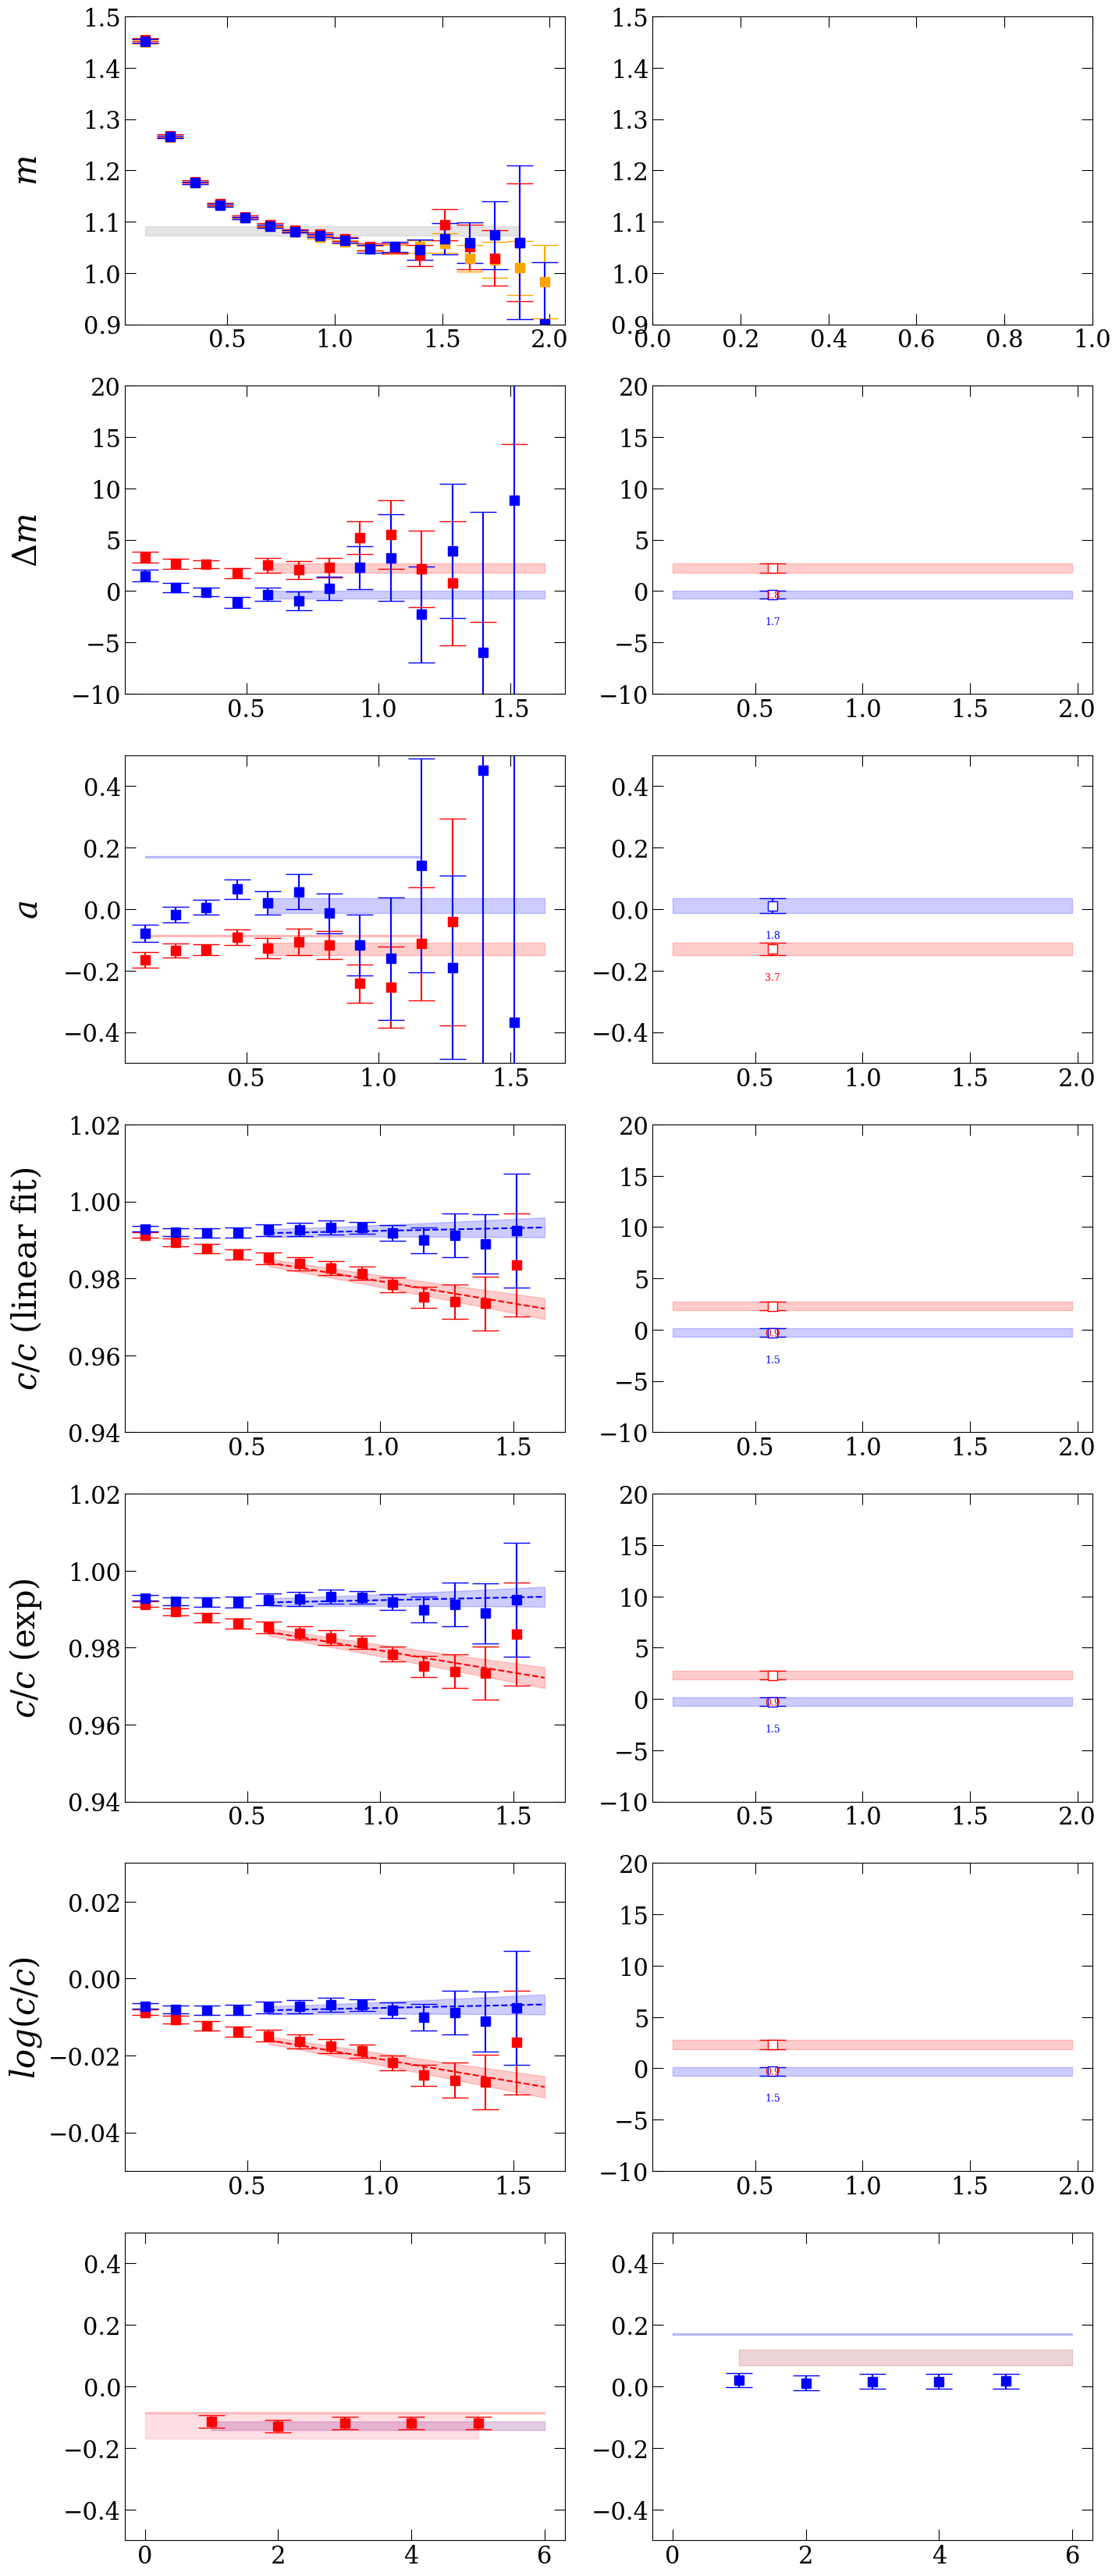

In [7]:
coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

mean,err=yu.jackme(c_32)
rela=np.abs(err/mean)
temp=[(i,r) for i,r in enumerate(rela) if r>0.1 and i!=0]
fitmax32=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
mean,err=yu.jackme(c_12)
rela=np.abs(err/mean)
temp=[(i,r) for i,r in enumerate(rela) if r>0.1 and i!=0]
fitmax12=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
fitmaxs=[fitmax32,fitmax12]
print(fitmaxs)
dfitminmax=3
fitmins=range(1,fitmax-dfitminmax)

fitmins=[5]
fitmaxs=[14,14]

func=lambda c:np.log(c/np.roll(c,-1))
meff_12=yu.jackmap(func,c_12)
meff_32=yu.jackmap(func,c_32)
meff_Npi=yu.jackmap(func,c_Npi)
meff_N=yu.jackmap(func,c_N)
meff_pi=yu.jackmap(func,c_pi)

a_32_mpi=np.array([[es2sl(mu,lat_NL,dE)*mpi for dE in dEs] for dEs,mu,mpi in zip(meff_32-meff_Npi,m_mu,m_pi)])
a_12_mpi=np.array([[es2sl(mu,lat_NL,dE)*mpi for dE in dEs] for dEs,mu,mpi in zip(meff_12-meff_Npi,m_mu,m_pi)])

Nrow=7
fig, axs = yu.getFigAxs(Nrow,2,Lrow=6,Lcol=8)
ylim_dm=[-10,20]
ylim_a=[-0.5,0.5]

axs[Nrow-1,0].set_ylim(ylim_a)
plt_x=np.array([0,Nrow-1]); plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
axs[Nrow-1,0].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)

plt_x=np.array([0,Nrow-2]); plt_y=a32mpi_delta[0]; plt_yerr=a32mpi_delta[1]
axs[Nrow-1,0].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='pink',alpha=0.5)

plt_x=np.array([1,Nrow-1]); plt_y=a32mpi_pol[0]; plt_yerr=a32mpi_pol[1]
axs[Nrow-1,0].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='purple',alpha=0.2)

axs[Nrow-1,1].set_ylim(ylim_a)
plt_x=np.array([0,Nrow-1]); plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
axs[Nrow-1,1].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)

plt_x=np.array([1,Nrow-1]); plt_y=a12mpi_pol[0]; plt_yerr=a12mpi_pol[1]
axs[Nrow-1,1].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='brown',alpha=0.2)

irow=0
ylim=[0.9,1.5]
axs[irow,0].set_ylim(ylim); axs[irow,1].set_ylim(ylim)
ax=axs[irow,0]; ax.set_ylabel(r'$m$')
xunit=lat_a; yunit=lat_aInv/1000
tmin=1; tmax=24

m_N_pi=m_N+m_pi
mean,err=yu.jackme(m_N_pi)
plt_x=np.array([1,16])*xunit; plt_y=mean*yunit; plt_err=err*yunit
ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2)

colors=['orange','r','b']
for icase in range(3):
    meff=[meff_Npi,meff_32,meff_12][icase]
    color=colors[icase]
    
    mean,err=yu.jackme(meff)
    rela=np.abs(err/mean)
    temp=[(i,r) for i,r in enumerate(rela) if r>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
    # fitmax=fitmaxs[icase]
    
    ax=axs[irow,0]
    xunit=lat_a; yunit=lat_aInv/1000
    plt_x=np.arange(tmin,fitmax)*xunit; plt_y=mean[tmin:fitmax]*yunit; plt_yerr=err[tmin:fitmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color)
    # print(i,fitmax)
    
    # fitmins=range(4,fitmax-3)
    # pars0=[0.2]
    # fits=[]
    # for fitmin in fitmins:
    #     tList=np.arange(fitmin,fitmax)
    #     def fitfunc(pars):
    #         return [pars[0]]*len(tList)
    #     y_jk=meff[:,tList]
        
    #     pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
    #     pars0=np.mean(pars_jk,axis=0)
    #     fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
    # pars_jk,props_jk=yu.jackMA(fits)
    # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    # mean,err=yu.jackme(pars_jk)
    # plt_x=np.array([fits[ind_mpf][0],fitmax])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    # ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2)    

    # ax=axs[irow,1]
    # plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    # ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2) 
    # for i,fit in enumerate(fits):
    #     fitmin,pars_jk,chi2_jk,Ndof=fit
    #     mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
    #     plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
    #     ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if i==ind_mpf else None)
    #     ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
    #     ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 

irow=1
axs[irow,0].set_ylim(ylim_dm); axs[irow,1].set_ylim(ylim_dm)
ax=axs[irow,0]; ax.set_ylabel(r'$\Delta m$')
colors=['r','b']

for icase in range(2):
    meff=[meff_32-meff_Npi,meff_12-meff_Npi][icase]
    color=colors[icase]
    
    mean,err=yu.jackme(meff)
    rela=np.abs(err/mean)
    temp=[(i,r) for i,r in enumerate(err) if r*yunit>5 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
    fitmax=10
    fitmax=fitmaxs[icase]
    
    ax=axs[irow,0]
    xunit=lat_a; yunit=lat_aInv
    plt_x=np.arange(tmin,fitmax)*xunit; plt_y=mean[tmin:fitmax]*yunit; plt_yerr=err[tmin:fitmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color)
    
    pars0=[0.2]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            return [pars[0]]*len(tList)
        y_jk=meff[:,tList]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
    
    pars_jk,props_jk=yu.jackMA(fits); 
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],fitmax])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2)    

    ax=axs[irow,1]
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2) 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
    
    ax=axs[Nrow-1,icase]
    xunit=1; yunit=1
    pars_jk,props_jk=yu.jackMA(fits)
    
    t=np.array([es2sl(mu,lat_NL,dE)*mpi for dE,mu,mpi in zip(pars_jk[:,0],m_mu,m_pi)])
    mean,err=yu.jackme(t)
    plt_x=[irow]; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color)
        
        
irow=2
axs[irow,0].set_ylim(ylim_a); axs[irow,1].set_ylim(ylim_a)
ax=axs[irow,0]; ax.set_ylabel(r'$a$')
xunit=lat_a; yunit=1
plt_x=np.array([tmin,10])*xunit; plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)  
plt_x=np.array([tmin,10])*xunit; plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)  

colors=['r','b']
for icase in range(2):
    meff=[a_32_mpi,a_12_mpi][icase]
    color=colors[icase]
    
    mean,err=yu.jackme(meff)
    rela=np.abs(err/mean)
    temp=[(i,r) for i,r in enumerate(err) if r*yunit>1 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
    fitmax=10
    fitmax=fitmaxs[icase]
    
    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    plt_x=np.arange(tmin,fitmax)*xunit; plt_y=mean[tmin:fitmax]*yunit; plt_yerr=err[tmin:fitmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color)
    # print(i,fitmax)

    pars0=[0.2]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            return [pars[0]]*len(tList)
        y_jk=meff[:,tList]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],fitmax])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2)    

    ax=axs[irow,1]
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2) 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
        
        
    ax=axs[Nrow-1,icase]
    xunit=1; yunit=1
    mean,err=yu.jackme(pars_jk[:,0])
    plt_x=[irow]; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color)

irow=3
ax=axs[irow,0]; ax.set_ylabel(r'$c/c$ (linear fit)')
ax.set_ylim([0.94,1.02])
colors=['r','b']
for icase in range(2):
    meff=[c_32/c_Npi,c_12/c_Npi][icase]
    color=colors[icase]
    
    mean,err=yu.jackme(meff)
    rela=np.abs(err/mean)
    temp=[(i,r) for i,r in enumerate(rela) if r>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
    # fitmax=15
    fitmax=fitmaxs[icase]
    
    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    plt_x=np.arange(tmin,fitmax)*xunit; plt_y=mean[tmin:fitmax]*yunit; plt_yerr=err[tmin:fitmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color)
    
    pars0=[0.2,1]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            dm,c=pars
            return [c*(1-dm*t) for t in tList]
        y_jk=meff[:,tList]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],fitmax])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    # ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2)    

    ax=axs[irow,1]; ax.set_ylim(ylim_dm)
    xunit=lat_a; yunit=lat_aInv
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2) 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 

    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    fitmin,pars_jk,chi2_jk,Ndof=fits[ind_mpf]
    tList=np.arange(fitmin,fitmax,0.1)
    def fitfunc(pars):
        dm,c=pars
        return [c*(1-dm*t) for t in tList]
    ys=np.array([fitfunc(pars) for pars in pars_jk])
    mean,err=yu.jackme(ys)
    x=tList*xunit; ymin=mean-err; ymax=mean+err
    ax.plot(x,mean,color=color,linestyle='--',marker='')
    ax.fill_between(x, ymin, ymax, color=color, alpha=0.2)
        
    ax=axs[Nrow-1,icase]
    xunit=1; yunit=1
    pars_jk,props_jk=yu.jackMA(fits)
    
    t=np.array([es2sl(mu,lat_NL,dE)*mpi for dE,mu,mpi in zip(pars_jk[:,0],m_mu,m_pi)])
    mean,err=yu.jackme(t)
    plt_x=[irow]; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color)
    
irow=4
ax=axs[irow,0]; ax.set_ylabel(r'$c/c$ (exp)')
ax.set_ylim([0.94,1.02])
colors=['r','b']
for icase in range(2):
    meff=[c_32/c_Npi,c_12/c_Npi][icase]
    color=colors[icase]
    
    mean,err=yu.jackme(meff)
    rela=np.abs(err/mean)
    temp=[(i,r) for i,r in enumerate(rela) if r>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
    # fitmax=15
    fitmax=fitmaxs[icase]
    
    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    plt_x=np.arange(tmin,fitmax)*xunit; plt_y=mean[tmin:fitmax]*yunit; plt_yerr=err[tmin:fitmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color)
    pars0=[0.2,1]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            dm,c=pars
            return c*np.exp(-dm*tList)
        y_jk=meff[:,tList]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],fitmax])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    # ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2)    

    ax=axs[irow,1]; ax.set_ylim(ylim_dm)
    xunit=lat_a; yunit=lat_aInv
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2) 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 

    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    fitmin,pars_jk,chi2_jk,Ndof=fits[ind_mpf]
    tList=np.arange(fitmin,fitmax,0.1)
    def fitfunc(pars):
        dm,c=pars
        return c*np.exp(-dm*tList)
    ys=np.array([fitfunc(pars) for pars in pars_jk])
    mean,err=yu.jackme(ys)
    x=tList*xunit; ymin=mean-err; ymax=mean+err
    ax.plot(x,mean,color=color,linestyle='--',marker='')
    ax.fill_between(x, ymin, ymax, color=color, alpha=0.2)
        
    ax=axs[Nrow-1,icase]
    xunit=1; yunit=1
    pars_jk,props_jk=yu.jackMA(fits)
    
    t=np.array([es2sl(mu,lat_NL,dE)*mpi for dE,mu,mpi in zip(pars_jk[:,0],m_mu,m_pi)])
    mean,err=yu.jackme(t)
    plt_x=[irow]; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color)

irow=5
ax=axs[irow,0]; ax.set_ylabel(r'$log(c/c)$')
ax.set_ylim([-0.05,0.03])
colors=['r','b']
res=[]
for icase in range(2):
    meff=[np.log(c_32/c_Npi),np.log(c_12/c_Npi)][icase]
    color=colors[icase]
    
    mean,err=yu.jackme(meff)
    rela=np.abs(err/mean)
    temp=[(i,r) for i,r in enumerate(rela) if r>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
    fitmax=12
    fitmax=fitmaxs[icase]
    
    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    plt_x=np.arange(tmin,fitmax)*xunit; plt_y=mean[tmin:fitmax]*yunit; plt_yerr=err[tmin:fitmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color)

    pars0=[0.2,1]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            dm,c=pars
            return c-dm*tList
        y_jk=meff[:,tList]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],fitmax])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    # ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2)    

    ax=axs[irow,1]; ax.set_ylim(ylim_dm)
    xunit=lat_a; yunit=lat_aInv
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2) 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 

    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    fitmin,pars_jk,chi2_jk,Ndof=fits[ind_mpf]
    tList=np.arange(fitmin,fitmax,0.1)
    def fitfunc(pars):
        dm,c=pars
        return c-dm*tList
    ys=np.array([fitfunc(pars) for pars in pars_jk])
    mean,err=yu.jackme(ys)
    x=tList*xunit; ymin=mean-err; ymax=mean+err
    ax.plot(x,mean,color=color,linestyle='--',marker='')
    ax.fill_between(x, ymin, ymax, color=color, alpha=0.2)
        
    ax=axs[Nrow-1,icase]
    xunit=1; yunit=1
    pars_jk,props_jk=yu.jackMA(fits)
    
    t=np.array([es2sl(mu,lat_NL,dE)*mpi for dE,mu,mpi in zip(pars_jk[:,0],m_mu,m_pi)])
    res.append(t)
    mean,err=yu.jackme(t)
    plt_x=[irow]; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color)

plt.savefig(f'fig/scatteringLength_Nsrc={Nsrc}.pdf')

a32_jk,a12_jk=res
sgm_jk=[a2sgm(a12/mpi/lat_aInv,a32/mpi/lat_aInv) for a32,a12,mpi in zip(a32_jk,a12_jk,m_pi)]
mean,err=yu.jackme(sgm_jk)
print(yu.un2str(mean,err))
print(np.mean(a12_jk)/np.mean(m_pi)/lat_aInv,np.mean(a32_jk)/np.mean(m_pi)/lat_aInv)
print(a12mpi_phy[0]/mpiC_phys,a32mpi_phy[0]/mpiC_phys)

sgm_jk=[a2sgm(a12/mpi/lat_aInv,a32mpi_phy[0]/mpiC_phys) for a32,a12,mpi in zip(a32_jk,a12_jk,m_pi)]
mean,err=yu.jackme(sgm_jk)
print(yu.un2str(mean,err),'a12 from wilson, a32 from phe')

sgm_jk=[a2sgm(a12mpi_phy[0]/mpiC_phys,a32/mpi/lat_aInv) for a32,a12,mpi in zip(a32_jk,a12_jk,m_pi)]
mean,err=yu.jackme(sgm_jk)
print(yu.un2str(mean,err),'a12 from phe, a32 from wilson')

print(a2sgm(a12mpi_phy[0]/mpiC_phys,a32mpi_phy[0]/mpiC_phys),'both from phe')

[14, 14]


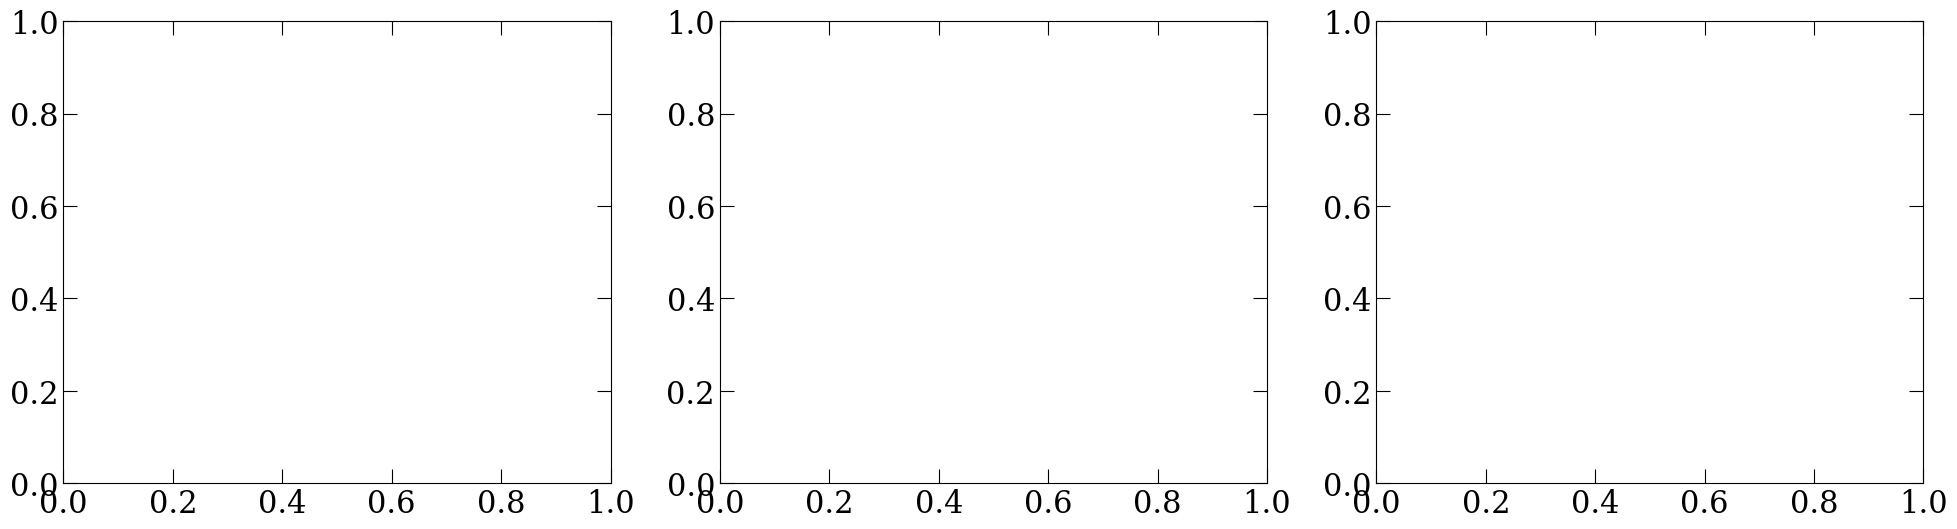

In [ ]:
coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

mean,err=yu.jackme(c_32)
rela=np.abs(err/mean)
temp=[(i,r) for i,r in enumerate(rela) if r>0.05 and i!=0]
fitmax32=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
mean,err=yu.jackme(c_12)
rela=np.abs(err/mean)
temp=[(i,r) for i,r in enumerate(rela) if r>0.05 and i!=0]
fitmax12=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
fitmaxs=[fitmax32,fitmax12]
print(fitmaxs)
dfitminmax=3
fitmins=range(1,np.min(fitmaxs)-dfitminmax)


Nrow=1
fig, axs = yu.getFigAxs(Nrow,3,Lrow=6,Lcol=8)
ylim_dm=[-10,20]
ylim_a=[-0.5,0.5]



ax=axs[irow,0]; ax.set_ylabel(r'$log(c/c)$')
ax.set_ylim([-0.05,0.03])
colors=['r','b']
res=[]
for icase in range(2):
    meff=[np.log(c_32/c_Npi),np.log(c_12/c_Npi)][icase]
    color=colors[icase]
    
    mean,err=yu.jackme(meff)
    rela=np.abs(err/mean)
    temp=[(i,r) for i,r in enumerate(rela) if r>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
    fitmax=12
    fitmax=fitmaxs[icase]
    
    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    plt_x=np.arange(tmin,fitmax)*xunit; plt_y=mean[tmin:fitmax]*yunit; plt_yerr=err[tmin:fitmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color)

    pars0=[0.2,1]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            dm,c=pars
            return c-dm*tList
        y_jk=meff[:,tList]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],fitmax])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    # ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2)    

    ax=axs[irow,1]; ax.set_ylim(ylim_dm)
    xunit=lat_a; yunit=lat_aInv
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2) 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/20
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
        
        t=np.array([es2sl(mu,lat_NL,dE)*mpi for dE,mu,mpi in zip(pars_jk[:,0],m_mu,m_pi)])
        mean,err=yu.jackme(t)
        plt_x=fitmin*xunit; plt_y=mean*1; plt_err=err*1
        axs[irow,2].errorbar(plt_x,plt_y,plt_err,fmt='s',color=color)
        ylim=axs[irow,2].get_ylim(); chi2_shift=(ylim[1]-ylim[0])/20
        axs[irow,2].annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 

    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    fitmin,pars_jk,chi2_jk,Ndof=fits[ind_mpf]
    tList=np.arange(fitmin,fitmax,0.1)
    def fitfunc(pars):
        dm,c=pars
        return c-dm*tList
    ys=np.array([fitfunc(pars) for pars in pars_jk])
    mean,err=yu.jackme(ys)
    x=tList*xunit; ymin=mean-err; ymax=mean+err
    ax.plot(x,mean,color=color,linestyle='--',marker='')
    ax.fill_between(x, ymin, ymax, color=color, alpha=0.2)
        
    ax=axs[Nrow-1,icase]
    xunit=1; yunit=1
    pars_jk,props_jk=yu.jackMA(fits)
    
    t=np.array([es2sl(mu,lat_NL,dE)*mpi for dE,mu,mpi in zip(pars_jk[:,0],m_mu,m_pi)])
    res.append(t)
    mean,err=yu.jackme(t)
    # print(mean,err)
    # 1/0
    plt_x=[irow]; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color)

In [20]:
coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

mean,err=yu.jackme(c_32)
rela=np.abs(err/mean)
temp=[(i,r) for i,r in enumerate(rela) if r>0.05 and i!=0]
fitmax32=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
mean,err=yu.jackme(c_12)
rela=np.abs(err/mean)
temp=[(i,r) for i,r in enumerate(rela) if r>0.05 and i!=0]
fitmax12=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
fitmaxs=[fitmax32,fitmax12]
print(fitmaxs)
dfitminmax=3
fitmins=range(1,np.min(fitmaxs)-dfitminmax)

func=lambda c:np.log(c/np.roll(c,-1))
meff_12=yu.jackmap(func,c_12)
meff_32=yu.jackmap(func,c_32)
meff_Npi=yu.jackmap(func,c_Npi)
meff_N=yu.jackmap(func,c_N)
meff_pi=yu.jackmap(func,c_pi)



for icase in range(1):
    meff=[np.log(c_32/c_Npi),np.log(c_12/c_Npi)][icase]
    
    pars0=[0.2,1]
    
    fitmin=11; fitmax=14
    tList=np.arange(fitmin,fitmax)
    def fitfunc(pars):
        dm,c=pars
        return c-dm*tList
    y_jk=meff[:,tList]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
    pars0=np.mean(pars_jk,axis=0)
    chi2=np.mean(chi2_jk)
    print(fitmin, pars0, chi2, chi2/Ndof)
    mean,err,cov=yu.jackmec(y_jk)
    print(cov)
    # print(np.linalg.inv(cov))
    t_pars0=pars0
    diff=fitfunc(pars0)-mean
    chi2=diff@np.linalg.inv(cov)@diff
    # print(chi2)
    
    fitmax=15
    tList=np.arange(fitmin,fitmax)
    def fitfunc(pars):
        dm,c=pars
        return c-dm*tList
    y_jk=meff[:,tList]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
    pars0=np.mean(pars_jk,axis=0)
    chi2=np.mean(chi2_jk)
    
    
    print(fitmin, pars0, chi2, chi2/Ndof)
    mean,err,cov=yu.jackmec(y_jk)
    # print(cov.shape)
    print(cov)
    
    t=cov
    tt=np.sqrt(np.diag(t))
    t=t/np.outer(tt,tt)
    print(t)
    
    # print(np.linalg.inv(cov))
    
    # ind=1
    # cov[-1,ind]=cov[ind,-1]=0

    diff=fitfunc(t_pars0)-mean
    chi2=diff@np.linalg.inv(cov)@diff
    # print(chi2)

[14, 14]
11 [0.00249621 0.00058367] 2.702230684666498 2.702230684666498
[[2.06971332e-05 2.92609529e-05 3.94954740e-05]
 [2.92609529e-05 5.05207490e-05 8.15754358e-05]
 [3.94954740e-05 8.15754358e-05 1.84230845e-04]]
11 [-0.00164155 -0.04009981] 8.594658646883708 4.297329323441854
[[2.06971332e-05 2.92609529e-05 3.94954740e-05 6.88138259e-05]
 [2.92609529e-05 5.05207490e-05 8.15754358e-05 1.43787991e-04]
 [3.94954740e-05 8.15754358e-05 1.84230845e-04 3.02917212e-04]
 [6.88138259e-05 1.43787991e-04 3.02917212e-04 5.82760739e-04]]
[[1.         0.9048956  0.63960384 0.62657846]
 [0.9048956  1.         0.84555788 0.83799723]
 [0.63960384 0.84555788 1.         0.92448025]
 [0.62657846 0.83799723 0.92448025 1.        ]]


[16, 16]
-17(29)
-0.00014501969979758528 -0.0008612925910147574
0.0012165938238876551 -0.0006183277208569177
59.100000000000016 both from phe


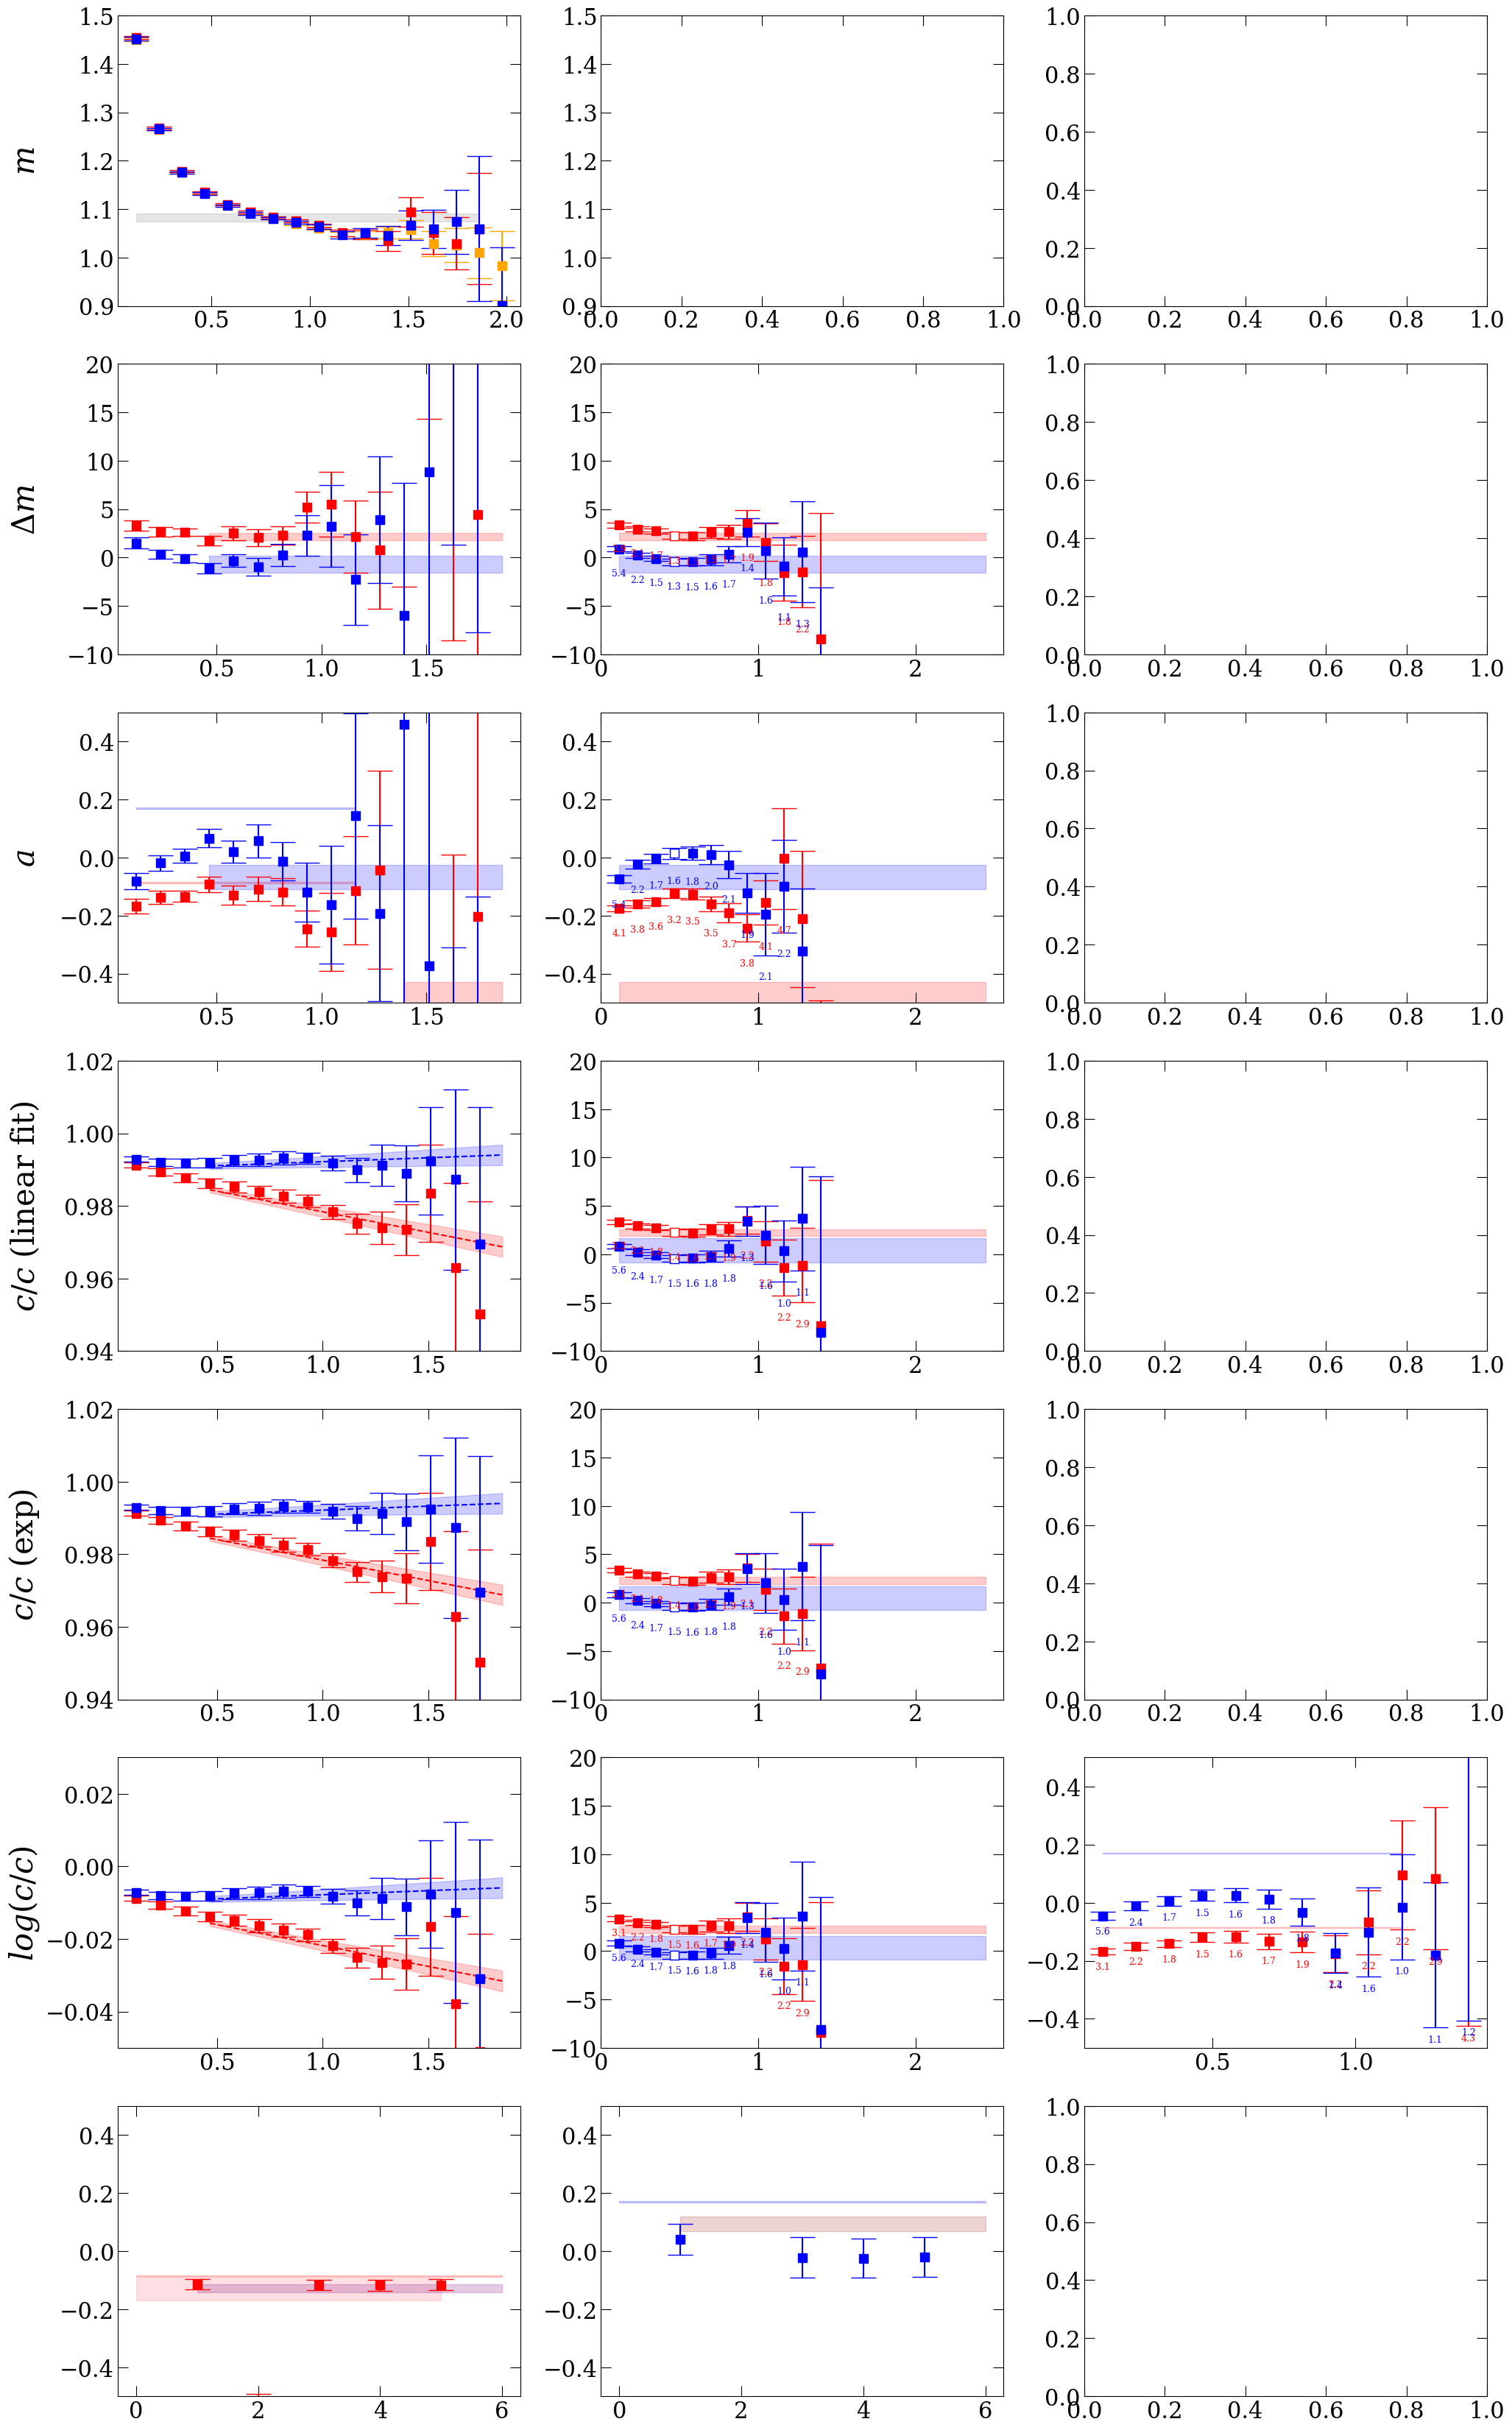

In [8]:
coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

mean,err=yu.jackme(c_32)
rela=np.abs(err/mean)
temp=[(i,r) for i,r in enumerate(rela) if r>0.1 and i!=0]
fitmax32=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
mean,err=yu.jackme(c_12)
rela=np.abs(err/mean)
temp=[(i,r) for i,r in enumerate(rela) if r>0.1 and i!=0]
fitmax12=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
fitmaxs=[fitmax32,fitmax12]
print(fitmaxs)
dfitminmax=3
fitmins=range(1,np.min(fitmaxs)-dfitminmax)

func=lambda c:np.log(c/np.roll(c,-1))
meff_12=yu.jackmap(func,c_12)
meff_32=yu.jackmap(func,c_32)
meff_Npi=yu.jackmap(func,c_Npi)
meff_N=yu.jackmap(func,c_N)
meff_pi=yu.jackmap(func,c_pi)

a_32_mpi=np.array([[es2sl(mu,lat_NL,dE)*mpi for dE in dEs] for dEs,mu,mpi in zip(meff_32-meff_Npi,m_mu,m_pi)])
a_12_mpi=np.array([[es2sl(mu,lat_NL,dE)*mpi for dE in dEs] for dEs,mu,mpi in zip(meff_12-meff_Npi,m_mu,m_pi)])

Nrow=7
fig, axs = yu.getFigAxs(Nrow,3,Lrow=6,Lcol=8)
ylim_dm=[-10,20]
ylim_a=[-0.5,0.5]

axs[Nrow-1,0].set_ylim(ylim_a)
plt_x=np.array([0,Nrow-1]); plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
axs[Nrow-1,0].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)

plt_x=np.array([0,Nrow-2]); plt_y=a32mpi_delta[0]; plt_yerr=a32mpi_delta[1]
axs[Nrow-1,0].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='pink',alpha=0.5)

plt_x=np.array([1,Nrow-1]); plt_y=a32mpi_pol[0]; plt_yerr=a32mpi_pol[1]
axs[Nrow-1,0].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='purple',alpha=0.2)

axs[Nrow-1,1].set_ylim(ylim_a)
plt_x=np.array([0,Nrow-1]); plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
axs[Nrow-1,1].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)

plt_x=np.array([1,Nrow-1]); plt_y=a12mpi_pol[0]; plt_yerr=a12mpi_pol[1]
axs[Nrow-1,1].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='brown',alpha=0.2)


xunit=lat_a
for irow in [5]:
    axs[irow,2].set_ylim(ylim_a)
    plt_x=np.array([tmin,10])*xunit; plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
    axs[irow,2].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)
    plt_x=np.array([tmin,10])*xunit; plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
    axs[irow,2].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)


irow=0
ylim=[0.9,1.5]
axs[irow,0].set_ylim(ylim); axs[irow,1].set_ylim(ylim)
ax=axs[irow,0]; ax.set_ylabel(r'$m$')
xunit=lat_a; yunit=lat_aInv/1000
tmin=1; tmax=24

m_N_pi=m_N+m_pi
mean,err=yu.jackme(m_N_pi)
plt_x=np.array([1,16])*xunit; plt_y=mean*yunit; plt_err=err*yunit
ax.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='grey',alpha=0.2)

colors=['orange','r','b']
for icase in range(3):
    meff=[meff_Npi,meff_32,meff_12][icase]
    color=colors[icase]
    
    mean,err=yu.jackme(meff)
    rela=np.abs(err/mean)
    temp=[(i,r) for i,r in enumerate(rela) if r>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
    # fitmax=fitmaxs[icase]
    
    ax=axs[irow,0]
    xunit=lat_a; yunit=lat_aInv/1000
    plt_x=np.arange(tmin,fitmax)*xunit; plt_y=mean[tmin:fitmax]*yunit; plt_yerr=err[tmin:fitmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color)
    # print(i,fitmax)
    
    # fitmins=range(4,fitmax-3)
    # pars0=[0.2]
    # fits=[]
    # for fitmin in fitmins:
    #     tList=np.arange(fitmin,fitmax)
    #     def fitfunc(pars):
    #         return [pars[0]]*len(tList)
    #     y_jk=meff[:,tList]
        
    #     pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
    #     pars0=np.mean(pars_jk,axis=0)
    #     fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
    # pars_jk,props_jk=yu.jackMA(fits)
    # ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    # mean,err=yu.jackme(pars_jk)
    # plt_x=np.array([fits[ind_mpf][0],fitmax])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    # ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2)    

    # ax=axs[irow,1]
    # plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    # ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2) 
    # for i,fit in enumerate(fits):
    #     fitmin,pars_jk,chi2_jk,Ndof=fit
    #     mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
    #     plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
    #     ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if i==ind_mpf else None)
    #     ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
    #     ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 

irow=1
axs[irow,0].set_ylim(ylim_dm); axs[irow,1].set_ylim(ylim_dm)
ax=axs[irow,0]; ax.set_ylabel(r'$\Delta m$')
colors=['r','b']
for icase in range(2):
    meff=[meff_32-meff_Npi,meff_12-meff_Npi][icase]
    color=colors[icase]
    
    mean,err=yu.jackme(meff)
    rela=np.abs(err/mean)
    temp=[(i,r) for i,r in enumerate(err) if r*yunit>5 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
    fitmax=10
    fitmax=fitmaxs[icase]
    
    ax=axs[irow,0]
    xunit=lat_a; yunit=lat_aInv
    plt_x=np.arange(tmin,fitmax)*xunit; plt_y=mean[tmin:fitmax]*yunit; plt_yerr=err[tmin:fitmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color)
    
    pars0=[0.2]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            return [pars[0]]*len(tList)
        y_jk=meff[:,tList]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
    
    pars_jk,props_jk=yu.jackMA(fits); 
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],fitmax])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2)    

    ax=axs[irow,1]
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2) 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
    
    ax=axs[Nrow-1,icase]
    xunit=1; yunit=1
    pars_jk,props_jk=yu.jackMA(fits)
    
    t=np.array([es2sl(mu,lat_NL,dE)*mpi for dE,mu,mpi in zip(pars_jk[:,0],m_mu,m_pi)])
    mean,err=yu.jackme(t)
    plt_x=[irow]; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color)
        
        
irow=2
axs[irow,0].set_ylim(ylim_a); axs[irow,1].set_ylim(ylim_a)
ax=axs[irow,0]; ax.set_ylabel(r'$a$')
xunit=lat_a; yunit=1
plt_x=np.array([tmin,10])*xunit; plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)  
plt_x=np.array([tmin,10])*xunit; plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)  

colors=['r','b']
for icase in range(2):
    meff=[a_32_mpi,a_12_mpi][icase]
    color=colors[icase]
    
    mean,err=yu.jackme(meff)
    rela=np.abs(err/mean)
    temp=[(i,r) for i,r in enumerate(err) if r*yunit>1 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
    fitmax=10
    fitmax=fitmaxs[icase]
    
    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    plt_x=np.arange(tmin,fitmax)*xunit; plt_y=mean[tmin:fitmax]*yunit; plt_yerr=err[tmin:fitmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color)
    # print(i,fitmax)

    pars0=[0.2]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            return [pars[0]]*len(tList)
        y_jk=meff[:,tList]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],fitmax])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2)    

    ax=axs[irow,1]
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2) 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
        
        
    ax=axs[Nrow-1,icase]
    xunit=1; yunit=1
    mean,err=yu.jackme(pars_jk[:,0])
    plt_x=[irow]; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color)

irow=3
ax=axs[irow,0]; ax.set_ylabel(r'$c/c$ (linear fit)')
ax.set_ylim([0.94,1.02])
colors=['r','b']
for icase in range(2):
    meff=[c_32/c_Npi,c_12/c_Npi][icase]
    color=colors[icase]
    
    mean,err=yu.jackme(meff)
    rela=np.abs(err/mean)
    temp=[(i,r) for i,r in enumerate(rela) if r>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
    # fitmax=15
    fitmax=fitmaxs[icase]
    
    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    plt_x=np.arange(tmin,fitmax)*xunit; plt_y=mean[tmin:fitmax]*yunit; plt_yerr=err[tmin:fitmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color)
    
    pars0=[0.2,1]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            dm,c=pars
            return [c*(1-dm*t) for t in tList]
        y_jk=meff[:,tList]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],fitmax])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    # ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2)    

    ax=axs[irow,1]; ax.set_ylim(ylim_dm)
    xunit=lat_a; yunit=lat_aInv
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2) 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 

    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    fitmin,pars_jk,chi2_jk,Ndof=fits[ind_mpf]
    tList=np.arange(fitmin,fitmax,0.1)
    def fitfunc(pars):
        dm,c=pars
        return [c*(1-dm*t) for t in tList]
    ys=np.array([fitfunc(pars) for pars in pars_jk])
    mean,err=yu.jackme(ys)
    x=tList*xunit; ymin=mean-err; ymax=mean+err
    ax.plot(x,mean,color=color,linestyle='--',marker='')
    ax.fill_between(x, ymin, ymax, color=color, alpha=0.2)
        
    ax=axs[Nrow-1,icase]
    xunit=1; yunit=1
    pars_jk,props_jk=yu.jackMA(fits)
    
    t=np.array([es2sl(mu,lat_NL,dE)*mpi for dE,mu,mpi in zip(pars_jk[:,0],m_mu,m_pi)])
    mean,err=yu.jackme(t)
    plt_x=[irow]; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color)
    
irow=4
ax=axs[irow,0]; ax.set_ylabel(r'$c/c$ (exp)')
ax.set_ylim([0.94,1.02])
colors=['r','b']
for icase in range(2):
    meff=[c_32/c_Npi,c_12/c_Npi][icase]
    color=colors[icase]
    
    mean,err=yu.jackme(meff)
    rela=np.abs(err/mean)
    temp=[(i,r) for i,r in enumerate(rela) if r>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
    # fitmax=15
    fitmax=fitmaxs[icase]
    
    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    plt_x=np.arange(tmin,fitmax)*xunit; plt_y=mean[tmin:fitmax]*yunit; plt_yerr=err[tmin:fitmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color)
    pars0=[0.2,1]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            dm,c=pars
            return c*np.exp(-dm*tList)
        y_jk=meff[:,tList]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],fitmax])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    # ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2)    

    ax=axs[irow,1]; ax.set_ylim(ylim_dm)
    xunit=lat_a; yunit=lat_aInv
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2) 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 

    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    fitmin,pars_jk,chi2_jk,Ndof=fits[ind_mpf]
    tList=np.arange(fitmin,fitmax,0.1)
    def fitfunc(pars):
        dm,c=pars
        return c*np.exp(-dm*tList)
    ys=np.array([fitfunc(pars) for pars in pars_jk])
    mean,err=yu.jackme(ys)
    x=tList*xunit; ymin=mean-err; ymax=mean+err
    ax.plot(x,mean,color=color,linestyle='--',marker='')
    ax.fill_between(x, ymin, ymax, color=color, alpha=0.2)
        
    ax=axs[Nrow-1,icase]
    xunit=1; yunit=1
    pars_jk,props_jk=yu.jackMA(fits)
    
    t=np.array([es2sl(mu,lat_NL,dE)*mpi for dE,mu,mpi in zip(pars_jk[:,0],m_mu,m_pi)])
    mean,err=yu.jackme(t)
    plt_x=[irow]; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color)

irow=5
ax=axs[irow,0]; ax.set_ylabel(r'$log(c/c)$')
ax.set_ylim([-0.05,0.03])
colors=['r','b']
res=[]
for icase in range(2):
    meff=[np.log(c_32/c_Npi),np.log(c_12/c_Npi)][icase]
    color=colors[icase]
    
    mean,err=yu.jackme(meff)
    rela=np.abs(err/mean)
    temp=[(i,r) for i,r in enumerate(rela) if r>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
    fitmax=12
    fitmax=fitmaxs[icase]
    
    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    plt_x=np.arange(tmin,fitmax)*xunit; plt_y=mean[tmin:fitmax]*yunit; plt_yerr=err[tmin:fitmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color)

    pars0=[0.2,1]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            dm,c=pars
            return c-dm*tList
        y_jk=meff[:,tList]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],fitmax])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    # ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2)    

    ax=axs[irow,1]; ax.set_ylim(ylim_dm)
    xunit=lat_a; yunit=lat_aInv
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2) 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/20
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
        
        t=np.array([es2sl(mu,lat_NL,dE)*mpi for dE,mu,mpi in zip(pars_jk[:,0],m_mu,m_pi)])
        mean,err=yu.jackme(t)
        plt_x=fitmin*xunit; plt_y=mean*1; plt_err=err*1
        axs[irow,2].errorbar(plt_x,plt_y,plt_err,fmt='s',color=color)
        ylim=axs[irow,2].get_ylim(); chi2_shift=(ylim[1]-ylim[0])/20
        axs[irow,2].annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 

    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    fitmin,pars_jk,chi2_jk,Ndof=fits[ind_mpf]
    tList=np.arange(fitmin,fitmax,0.1)
    def fitfunc(pars):
        dm,c=pars
        return c-dm*tList
    ys=np.array([fitfunc(pars) for pars in pars_jk])
    mean,err=yu.jackme(ys)
    x=tList*xunit; ymin=mean-err; ymax=mean+err
    ax.plot(x,mean,color=color,linestyle='--',marker='')
    ax.fill_between(x, ymin, ymax, color=color, alpha=0.2)
        
    ax=axs[Nrow-1,icase]
    xunit=1; yunit=1
    pars_jk,props_jk=yu.jackMA(fits)
    
    t=np.array([es2sl(mu,lat_NL,dE)*mpi for dE,mu,mpi in zip(pars_jk[:,0],m_mu,m_pi)])
    res.append(t)
    mean,err=yu.jackme(t)
    # print(mean,err)
    # 1/0
    plt_x=[irow]; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color)

plt.savefig(f'fig/scatteringLength_modelAvg_Nsrc={Nsrc}.pdf')

a32_jk,a12_jk=res
sgm_jk=[a2sgm(a12/mpi/lat_aInv,a32/mpi/lat_aInv) for a32,a12,mpi in zip(a32_jk,a12_jk,m_pi)]
mean,err=yu.jackme(sgm_jk)
print(yu.un2str(mean,err))
print(np.mean(a12_jk)/np.mean(m_pi)/lat_aInv,np.mean(a32_jk)/np.mean(m_pi)/lat_aInv)
print(a12mpi_phy[0]/mpiC_phys,a32mpi_phy[0]/mpiC_phys)

# sgm_jk=[a2sgm(a12/mpi/lat_aInv,a32mpi_phy[0]/mpiC_phys) for a32,a12,mpi in zip(a32_jk,a12_jk,m_pi)]
# mean,err=yu.jackme(sgm_jk)
# print(yu.un2str(mean,err),'a12 from wilson, a32 from phe')

# sgm_jk=[a2sgm(a12mpi_phy[0]/mpiC_phys,a32/mpi/lat_aInv) for a32,a12,mpi in zip(a32_jk,a12_jk,m_pi)]
# mean,err=yu.jackme(sgm_jk)
# print(yu.un2str(mean,err),'a12 from phe, a32 from wilson')

print(a2sgm(a12mpi_phy[0]/mpiC_phys,a32mpi_phy[0]/mpiC_phys),'both from phe')

# backup


In [ ]:
# sigma term to lattice scattering length 1/2 # Hoferichter:2016ocj
mpiC_phys=139.57
sgm_center=59.1
a12_center=169.8*1e-3 * (mpiC_phys**-1); a12_error=2.0*1e-3 * (mpiC_phys**-1)
a32_center=-86.3*1e-3 * (mpiC_phys**-1); a32_error=1.8*1e-3 * (mpiC_phys**-1)
a12_center_pheLat=178.8*1e-3 * (mpiC_phys**-1); a12_error_pheLat=3.8*1e-3 * (mpiC_phys**-1)
a32_center_pheLat=-77.5*1e-3 * (mpiC_phys**-1); a32_error_pheLat=3.5*1e-3 * (mpiC_phys**-1)

def a2sgm(a12,a32):
    c12=0.242*1e3*mpiC_phys
    c32=0.874*1e3*mpiC_phys
    return sgm_center + c12*(a12-a12_center) + c32*(a32-a32_center)

def sgm2a12(sgm):    
    c12=0.242*1e3*mpiC_phys
    c32=0.874*1e3*mpiC_phys
    return a12_center + (sgm-sgm_center)/c12

# scattering length <-> energy shift
def sl2es(mu, L, a0):
    c1=-2.837297; c2=6.375183
    return - (2*np.pi)/(mu*L) * a0/L * ( 1 + c1*a0/L + c2*(a0/L)**2 ) / L
def es2sl(mu, L, dE):
    return yu.fsolve2(lambda a0:sl2es(mu, L, a0)-dE, 0)

mN=931; mpi=131
mu=1/(1/mN+1/mpi); L=4.5 * hbarc

print(f'1/2: {sl2es(mu,L,a12_center)}, 3/2: {sl2es(mu,L,a32_center)}')

for sgm in [40,60]:
    print(f'{sgm}: {sl2es(mu,L,sgm2a12(sgm))}')
    
es2sl(mu,L,-5),a12_center

# a2sgm(0.169*mpiC_phys**-1/2,-0.1*mpiC_phys**-1)

a2sgm(0.123*(mpiC_phys**-1),-0.098*(mpiC_phys**-1))

1/2: -4.86473912395479, 3/2: 3.085302012686854
40: -2.775974591170151
60: -4.956882313254664


37.54860000000001

In [ ]:
mN=938/lat_aInv
mpi=140/lat_aInv
mu=1/(1/mN+1/mpi) 
L=48

def sl2es(a0):
    c1=-2.837297; c2=6.375183
    return - (2*np.pi)/(mu*L) * a0/L * ( 1 + c1*a0/L + c2*(a0/L)**2 ) / L
def es2sl(dE):
    return yu.fsolve2(lambda a0:sl2es(a0)-dE, 0)


a12_center=169.8*1e-3 * (mpiC_phys**-1); a12_error=2.0*1e-3 * (mpiC_phys**-1)
a32_center=-86.3*1e-3 * (mpiC_phys**-1); a32_error=1.8*1e-3 * (mpiC_phys**-1)

In [ ]:
err0=[
-1,0.7176293650887376,0.8484246047996062,1.6845446154606287,1.5574323938333194,2.3357941585409687,4.168040649035933,4.079015080084296,2.8635940393413244,4.398430894333734,10.104730636443914,10.569501699999826,7.5740361422562135,7.309697418412301,12.414965404157343,21.975794728064326,-1,164.678714368974,105.50306724082786,351.68760032442907,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,93.8740255159134,130.90098726035848,33.2722122575584,38.80890600828144,133.46180665555516,75.42064551582715,77.84533752993318,20.225201475521047,12.448848017761977,47.72086487057054,45.80484702488153,43.473051122527025,7.638127893203694,5.258667976000102,5.496635502295384,1.1367316815112027,1.3014761954473029,-1
]
err0_a_32=[err if err!=-1 else np.nan for err in err0]

err0=[
-1,0.8281736530389221,1.0757334300347527,2.0244934182799628,1.924407721905035,3.523042264207582,6.070184857331957,6.169742139778305,3.395736456968233,4.383166221377594,4.87268796235176,24.434689299341002,8.601863533669814,18.351329744882168,11.97976944606521,50.65513669897895,-1,36.392822413990245,276.5717242431672,226.2789202211941,-1,-1,-1,-1,-1,-1,-1,133.23494135458182,-1,-1,36.8090162751547,26.484388966464405,37.900455056142384,82.57157365723796,94.45897304259239,80.76314812176648,20.870550459229825,27.495026396478824,28.29553052085408,35.04301454217607,4.4005680581214115,5.840888983127969,2.7286124475142497,1.8379349652470605,1.4167206865933504,0.4650215515796708,0.5201736607118861,-1
]
err0_a_12=[err if err!=-1 else np.nan for err in err0]

err0=[
0.28411287,0.003607699,0.0041817757,0.00476746,0.0052661765,0.0058508622,0.006877304,0.00864523,0.010593608,0.011299904,0.01543012,0.01542755,0.028221773,0.061242554,0.08370036,0.12791435,0.23585822,0.71026963,2.6046984,74.39445,30.74815,33.004707,3.3806143,5.2271953,3.9798684,10.022676,5.226797,4.9817896,11.887033,173.0519,6.3944154,1.7017068,0.93387514,0.76471084,0.81532544,0.51068425,0.39554372,0.30492997,0.25612992,0.16325879,0.12756453,0.07508336,0.02666656,0.016316604,0.009983392,0.0046465546,0.0035774235,0.003030088
]
err0_rc_32=[err if err!=-1 else np.nan for err in err0]

err0=[
0.30234566,0.0036063276,0.004233063,0.004827389,0.005246635,0.0058528455,0.006851136,0.008520525,0.01039992,0.010282489,0.016554289,0.017034523,0.03202085,0.076202594,0.093625665,0.115678184,0.36304662,0.9492281,2.604198,91.16627,38.92444,20.012466,3.6523385,15.957423,5.351136,6.2625813,16.569973,6.3942394,14.308757,3196.5142,7.691272,1.4416125,1.0905861,1.2406175,0.9595508,0.4818323,0.7462011,0.5672473,0.3342754,0.21985348,0.12555385,0.07497338,0.028865324,0.018148175,0.009745785,0.0046030986,0.0035096812,0.0030917241
]
err0_rc_12=[err if err!=-1 else np.nan for err in err0]

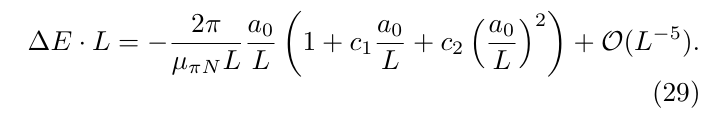

$\Delta E \sim L^{-3}$

L ~ 4.63/4.58 (polarizability), 5.1 (delta), 5.6 (Wilson)

a_32
[ nan 11.4 12.8 67.5 23.  25.6 49.  39.8 11.9  6.6]
a_12
[ nan  9.5 10.  41.3  8.5 30.9 33.9 20.9  2.2  1.8]
rc_32
[ 0.  43.8 34.2 29.5 27.9 24.2 23.7 26.6 29.9 21.6]
rc_12
[ 0.  41.8 32.8 27.9 25.  20.6 21.9 24.3 19.7 10.3]


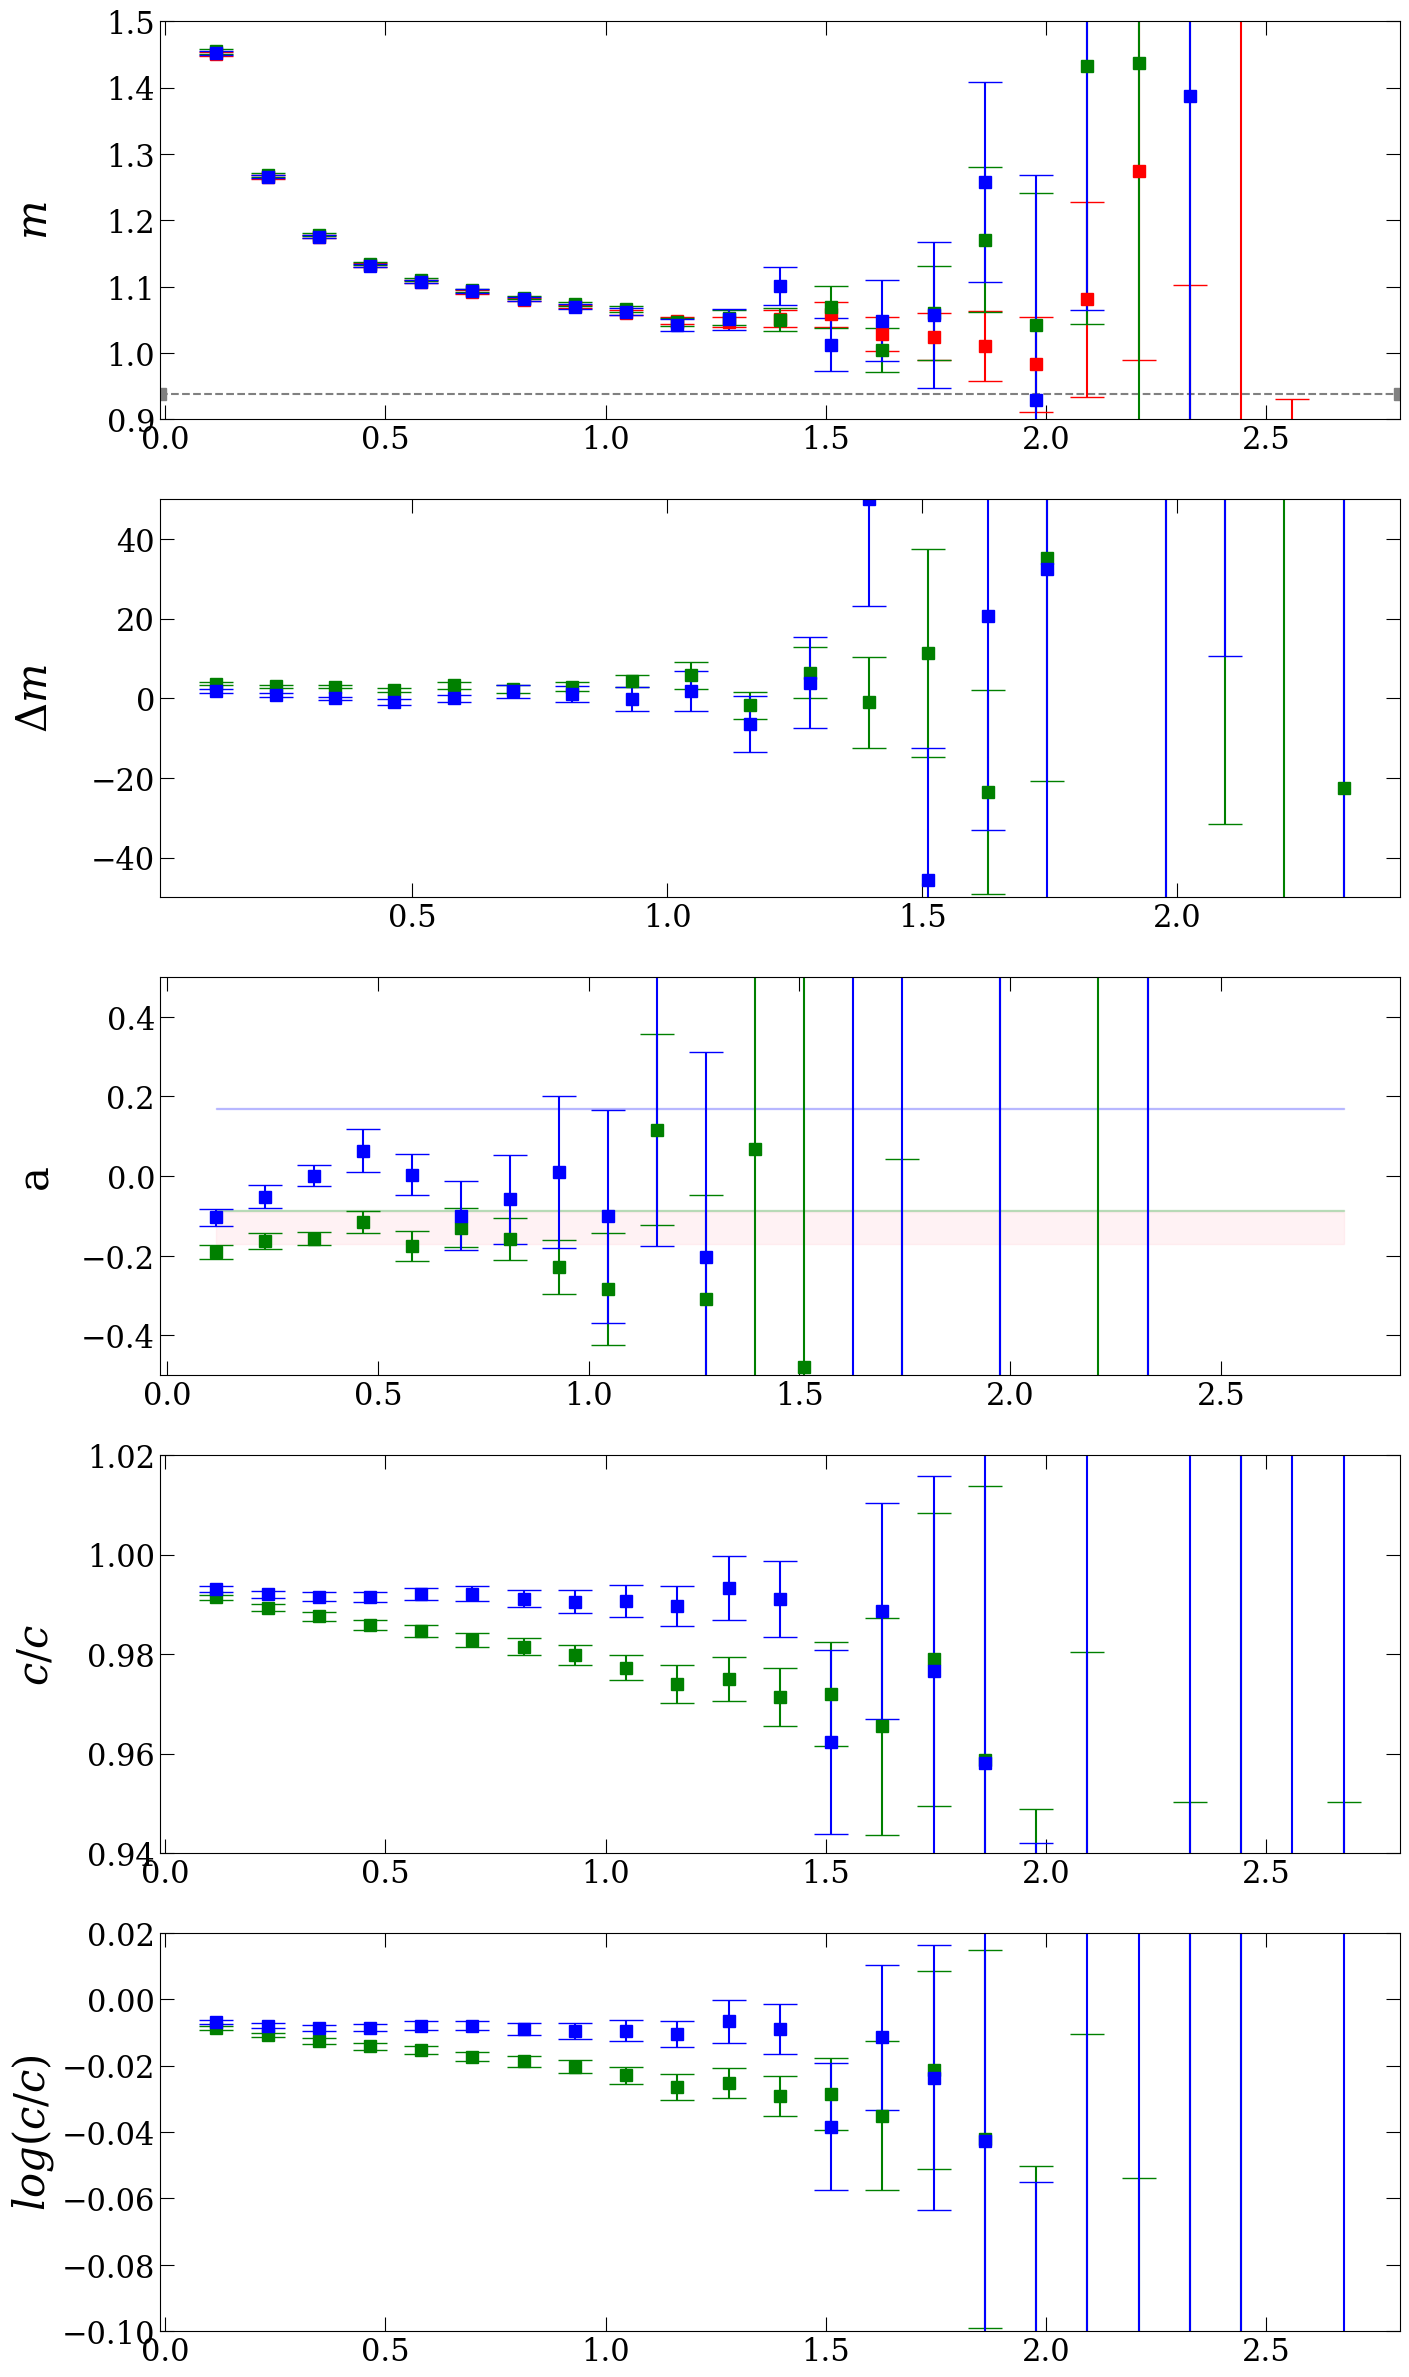

In [ ]:
np.set_printoptions(suppress=True,precision=1)

coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=1

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

func=lambda c:np.log(c/np.roll(c,-1))
m_12=yu.jackmap(func,c_12)
m_32=yu.jackmap(func,c_32)
m_Npi=yu.jackmap(func,c_Npi)
m_N=yu.jackmap(func,c_N)
m_pi=yu.jackmap(func,c_pi)

func=lambda dEs:[es2sl(dE) for dE in dEs]
a_32=yu.jackmap(func,m_32-m_Npi)
a_12=yu.jackmap(func,m_12-m_Npi)

fig, axs = yu.getFigAxs(5,1,Lrow=6,Lcol=16)

ax=axs[0,0]; ax.set_ylabel(r'$m$')
xunit=lat_a; yunit=lat_aInv/1000
tmin=1; tmax=24
ax.set_ylim([0.9,1.5])
ax.axhline(0.938,color='grey',ls='--')


mean,err=yu.jackme(m_Npi)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

mean,err=yu.jackme(m_32)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

mean,err=yu.jackme(m_12)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

ax=axs[1,0]; ax.set_ylabel(r'$\Delta m$')
xunit=lat_a; yunit=lat_aInv
ax.set_ylim([-50,50])

mean,err=yu.jackme(m_32-m_Npi)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

mean,err=yu.jackme(m_12-m_Npi)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

ax=axs[2,0]; ax.set_ylabel(r'a')
xunit=lat_a; yunit=mpi
ax.set_ylim([-0.5,0.5])

plt_x=np.array([tmin,tmax])*xunit; plt_y=-86.3*1e-3; plt_yerr=1.8*1e-3
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='g',alpha=0.2)  
plt_x=np.array([tmin,tmax])*xunit; plt_y=169.8*1e-3; plt_yerr=2.0*1e-3
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)  

plt_x=np.array([tmin,tmax])*xunit; plt_y=-0.13; plt_yerr=0.04
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='pink',alpha=0.2)  


mean,err=yu.jackme(a_32)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

t=(err0_a_32/err)**2
print('a_32')
print(t[:10])

mean,err=yu.jackme(a_12)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

t=(err0_a_12/err)**2
print('a_12')
print(t[:10])

ax=axs[3,0]; ax.set_ylabel(r'$c/c$')
xunit=lat_a; yunit=1

mean,err=yu.jackme(c_32/c_Npi)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

t=(err0_rc_32/err)**2
print('rc_32')
print(t[:10])

mean,err=yu.jackme(c_12/c_Npi)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

t=(err0_rc_12/err)**2
print('rc_12')
print(t[:10])

ax.set_ylim([0.94,1.02])

ax=axs[4,0]; ax.set_ylabel(r'$log(c/c)$')
xunit=lat_a; yunit=1

mean,err=yu.jackme(np.log(c_32/c_Npi))
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

mean,err=yu.jackme(np.log(c_12/c_Npi))
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')
ax.set_ylim([-0.1,0.02])
None

plt.savefig(f'fig/Nsrc500_Nstoc{Nstoc}.pdf')
# plt.savefig(f'fig/Nsrc500_Nstoctemp.pdf')

800 nh for 200*50

Delta: 400*256

Polarizability: 200*1024

In [ ]:
coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['1','1','1']

def func(dat):
    Ncfg=len(dat)
    return np.repeat(np.mean(dat,axis=0)[None,:],Ncfg,axis=0)
c=[np.real(data['M'][:,:,0])]+[np.real(np.sum([cont[0]*np.mean(data[f'{cont[1]}_{method}'],axis=2) for cont in conts],axis=0)) for conts,method in zip(coeffs_12,method)]
c=[func(c[0]),func(c[1]),func(c[2]),func(c[3])]
c_12=np.sum(c,axis=0)

c=[np.real(data['M'][:,:,0])]+[np.real(np.sum([cont[0]*np.mean(data[f'{cont[1]}_{method}'],axis=2) for cont in conts],axis=0)) for conts,method in zip(coeffs_32,method)]
c=[func(c[0]),func(c[1]),func(c[2]),func(c[3])]
c_32=np.sum(c,axis=0)

c_Npi=func(np.real(data['N']*data['P']))
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

func=lambda c:np.log(c/np.roll(c,-1))
m_12=yu.jackmap(func,c_12)
m_32=yu.jackmap(func,c_32)
m_Npi=yu.jackmap(func,c_Npi)
m_N=yu.jackmap(func,c_N)
m_pi=yu.jackmap(func,c_pi)

fig, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=16)

ax=axs[0,0]
tmin=1; tmax=24
xunit=lat_a; yunit=lat_aInv
ax.set_ylim([-50,50])

mean,err=yu.jackme(m_32-m_Npi)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

mean,err=yu.jackme(m_12-m_Npi)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')


KeyError: 'B114_1'